Mounted at /content/drive


## 2부 - 가. 발표 개요 (모델링 이후) - datatrilogy 


### 모델 학습 순서 (선생님 제시 가이드라인) 

A. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

B. Create model instance variable

c. Train the model

D. Predict on test data & Check the result with metrics 

### 사용한 모델 

Robust Scaling + Gradient Boosting Classifier 

Robust Scaling ) 
- MinMaxSclaer(범위조정) : 단위가 다를 경우 비교불가
- StandardScalar(평균0,분산1, 최솟값과 최댓값의 크기 제한 X, 이상치가 있을 경우 민감하게 반응) 
- RobustScaler (특성들이 같은 스케일을 갖게 되지만 평균대신 중앙값을 사용 ==> 극단값에 영향을 받지 않음) 

동일한 조건에서 대체적으로 Gradient Boosting Classifier가 나은 성능을 보임

시도한 모델 

- LogisticRegression
- RandomForest
- GradientboostingClassifier
- HistGradientBoostingClassifier (히스토그램 기반)
- SVM Classifier 



### 모델 적용시 
순서

A. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)
- 데이터 셋 생성 
- EDA 도출 결과에 따른 전처리, 훈련용 및 테스트 데이터에 적용 
- SMOTE를 활용한 오버샘플링 (클래스 불균형 문제 해소) 

B&C. Create model instance variable & Train the model
- KFOLD 교차검증 적용 => 적용 이유 : 과적합 방지
- 여러가지 모델을 사용하는 Model Stacking 사용X
- makepipeline 
- 정규화와 모델에 적용하는 과정 한번에 실행

D. Predict on test data & Check the result with metrics 
- 모델 학습 후  테스트 데이터로 예측
- 두 가지 과정에서 Confusion Matrix 로 결과 비교 

- 하이퍼 파라미터 찾는 과정(그리드 서치 활용), 여러가지 시도 

## 나. 모델 생성 및 학습 단계 3가지 경우로 분리 


- 다중공선성이 높은 열을 제외하고 프로젝트를 진행하려했는데, 
- 열을 제외한다 == 정보손실
- 조금이라도 정확성을 높이기 위해서 
- 이것들을 포함하고 비교해보라는 강사님의 첨언

> ***Phase 3*** >  앞서 다중공선성이 확인된(VIF 분산팽창요인이 높게 나온) 칼럼들에 대해서 분리를 하고 모델 학습

분리 컬럼 : 'Ticket', 'Name', 'Cabin', 'Parch', 'Fare'

> ***Phase 2*** > Parch(부모자식), Fare(요금) 컬럼 포함  

> ***Phase 1*** > Parch, Fare + Cabin (컬럼) 포함 

- 이후 
  1. 그리드 서치 
  2. 실험 및 시도 
  3. 부록 


In [ ]:
# 환경세팅
from google.colab import drive

# 구글 드라이브 마운트 
drive.mount("/content/drive")

import pandas as pd 
import numpy as np 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Phase 3. 분리 컬럼 : 'Ticket', 'Name', 'Cabin', 'Parch', 'Fare'


#### A. [데이터 셋 생성]  Train - Test split

In [ ]:
from sklearn.model_selection import train_test_split

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/도원결의 시즌2/dowon/도원/titanic.csv', encoding='utf-8', engine='python')


# Train_Test_split 

x_train, x_test, y_train, y_test = train_test_split(
    df.drop(['Survived'], axis=1),
    df['Survived'],
    test_size=0.3, shuffle=True, stratify=df['Survived']
)

In [ ]:
x_train.shape

(712, 11)

In [ ]:
x_test.shape

(179, 11)

In [ ]:
y_train.shape

(712,)

In [ ]:
y_test.shape

(179,)

In [ ]:
#@title 학습용 데이터 처리 

from sklearn.preprocessing import LabelEncoder

import math
import warnings

warnings.filterwarnings("ignore")

# train 데이터 셋에 대한 df => Age에 결측값에 mean()으로 채워넣기 위한 빌드업
df = pd.concat([x_train, y_train], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)
df.head()

## 성별 열 처리
encoder = LabelEncoder()
df.Sex = encoder.fit_transform(df.Sex)

## 나이 열 결측값 채우기
cond_1 = df.loc[(df.SibSp == 0) & (df.Parch == 0)].index
cond_2 = df.loc[(df.Pclass == 3) | (df.Sex == "male") | (df.Survived == 0)].index
new_df = df.loc[cond_1 & cond_2]
df.Age.fillna(int(round(new_df.Age.mean(), 0)), inplace=True)
df.loc[df.Age % 1 != 0, "Age"] = df.loc[df.Age % 1 != 0, "Age"].apply(math.floor)
df.Age = df.Age.astype(int)

## Embarked 기항지 컬럼 처리 [결측값, 원핫인코딩]
df.Embarked.fillna("S", inplace=True)
df = pd.concat([df, pd.get_dummies(df.Embarked)], axis=1)
df.drop(['Embarked'], axis=1, inplace=True)

In [ ]:
#@title test 데이터 처리

## Sex column 처리
encoder = LabelEncoder()
df_test.Sex = encoder.fit_transform(df_test.Sex)

## Age column 결측값 채우기
cond_1 = df.loc[(df.SibSp == 0) & (df.Parch == 0)].index
cond_2 = df.loc[(df.Pclass == 3) | (df.Sex == "male") | (df.Survived == 0)].index
new_df = df.loc[cond_1 & cond_2]

df_test.Age.fillna(int(round(new_df.Age.mean(), 0)), inplace=True)
df_test.loc[df_test.Age % 1 != 0, "Age"] = df_test.loc[df_test.Age % 1 != 0, "Age"].apply(math.floor)
df_test.Age = df_test.Age.astype(int)

## Embarked column 처리 [결측값, 원핫인코딩]
df_test.Embarked.fillna("S", inplace=True)
df_test = pd.concat([df_test, pd.get_dummies(df_test.Embarked)], axis=1)
df_test.drop(['Embarked'], axis=1, inplace=True)

## object column 6가지['PassengerId', 'Ticket', 'Name', 'Cabin', 'Parch', 'Fare'] 제거
df_test.drop(['PassengerId', 'Ticket', 'Name', 'Cabin', 'Parch', 'Fare'], axis=1, inplace=True)
df.drop(['PassengerId', 'Ticket', 'Name', 'Cabin', 'Parch', 'Fare'], axis=1, inplace=True)

x_train = df.drop(['Survived'], axis=1)
x_test = df_test.drop(['Survived'], axis=1)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 분산팽창요인 확인 
# VIF 

temp_df = pd.DataFrame()
X = x_train.copy()
x_train.drop(['S'], axis=1, inplace=True)
x_test.drop(['S'], axis=1, inplace=True)
X.drop(['S'], axis=1, inplace=True)
temp_df['Feature'] = X.columns
temp_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
temp_df

,Feature,VIF
0,Pclass,4.534784
1,Sex,2.962116
2,Age,3.704785
3,SibSp,1.251018
4,C,1.232195
5,Q,1.200616


In [ ]:
#@title 오버샘플링
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

smote = SMOTE(random_state=42) # SMOTE 객체 생성

# 그냥 전처리가 아니라 단순히 SMOTE 기법을 시도하는 것이기 때문에 그냥 다버리고 오버샘플링 한번 보자.
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)

pd.DataFrame(y_train_over).Survived.value_counts() # SMOTE 를 활용한 오버샘플링 적용 된 것 확인

0    439
1    439
Name: Survived, dtype: int64

In [ ]:
#@title 언더샘플링
# y_train_df = pd.DataFrame(y_train, columns=["Survived"])
# idx_0 = y_train_df.loc[y_train_df.Survived == 0].sample(y_train.value_counts()[1], random_state=68).index.tolist()
# idx_1 = y_train_df.loc[y_train_df.Survived == 1].index.tolist()
# random_idx = idx_0 + idx_1
# x_train_under = x_train.loc[random_idx]
# y_train_under = y_train_df.loc[random_idx]

# print(y_train_under.value_counts(), '\n')

#### B&C. [학습 & 검증] Create model instance variable & Train the model

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3648           0.0202            2.13s
         2           1.3352           0.0183            2.58s
         3           1.3250           0.0175            5.15s
         4           1.3077           0.0165            4.46s
         5           1.2856           0.0155            4.23s
         6           1.2601           0.0141            3.89s
         7           1.2484           0.0136            4.59s
         8           1.2580           0.0132            4.29s
         9           1.2487           0.0125            4.05s
        10           1.2125           0.0117            3.99s
        20           1.1343           0.0067            4.85s
        30           1.0916           0.0044            5.42s
        40           1.0345           0.0031            5.82s
        50           1.0373           0.0026            5.86s
        60           0.9623           0.0020            5.63s
       

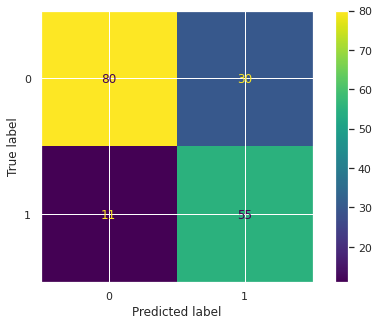

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3659           0.0194            2.85s
         2           1.3379           0.0180            3.44s
         3           1.3292           0.0172            3.00s
         4           1.3100           0.0162            4.67s
         5           1.2885           0.0152            4.18s
         6           1.2694           0.0138            3.82s
         7           1.2586           0.0135            3.55s
         8           1.2736           0.0127            4.68s
         9           1.2575           0.0122            5.12s
        10           1.2345           0.0117            5.72s
        20           1.1718           0.0058            4.64s
        30           1.0625           0.0048            3.54s
        40           1.0385           0.0035            2.97s
        50           1.0196           0.0026            3.11s
        60           0.9565           0.0015            3.08s
       

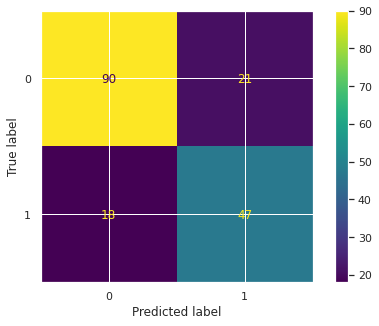

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3702           0.0193            1.80s
         2           1.3325           0.0178            2.17s
         3           1.3247           0.0171            4.99s
         4           1.3256           0.0156            4.35s
         5           1.3008           0.0153            4.83s
         6           1.2724           0.0141            4.38s
         7           1.2585           0.0136            4.05s
         8           1.2692           0.0128            3.90s
         9           1.2386           0.0122            3.73s
        10           1.2326           0.0116            3.56s
        20           1.1377           0.0068            2.82s
        30           1.0811           0.0049            3.16s
        40           1.0415           0.0030            3.16s
        50           1.0172           0.0028            2.86s
        60           0.9703           0.0018            2.60s
       

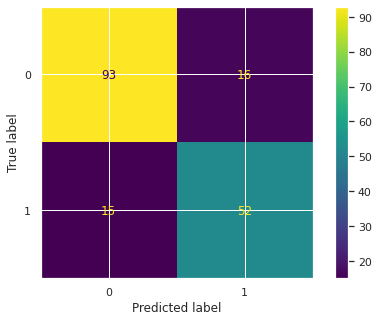

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3646           0.0196            1.77s
         2           1.3378           0.0180            2.23s
         3           1.3313           0.0172            2.29s
         4           1.3109           0.0163            2.30s
         5           1.2952           0.0154            2.38s
         6           1.2798           0.0144            2.35s
         7           1.2572           0.0133            2.33s
         8           1.2444           0.0127            2.32s
         9           1.2376           0.0118            2.31s
        10           1.2301           0.0114            2.30s
        20           1.1305           0.0066            2.12s
        30           1.1195           0.0029            1.97s
        40           1.0565           0.0034            1.93s
        50           1.0069           0.0025            1.84s
        60           0.9560           0.0017            1.77s
       

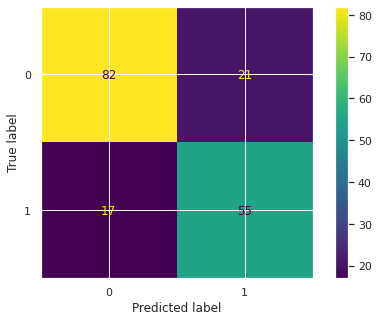

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3072           0.0169            1.67s
         2           1.3304           0.0153            2.26s
         3           1.2816           0.0145            2.27s
         4           1.2773           0.0136            2.26s
         5           1.2681           0.0132            2.24s
         6           1.2599           0.0123            2.24s
         7           1.2087           0.0114            2.23s
         8           1.2347           0.0106            2.22s
         9           1.1861           0.0096            2.19s
        10           1.1910           0.0097            2.16s
        20           1.1553           0.0048            1.82s
        30           1.1030           0.0041            2.10s
        40           1.0638           0.0024            2.02s
        50           1.0115           0.0017            2.01s
        60           1.0051          -0.0002            1.98s
       

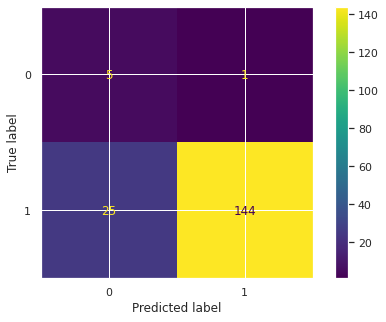


===================[검증]===================
acc_mean : 0.8007207792207792
rec_mean : 0.789697910840276
prec_mean : 0.7639457670545532
f1_mean : 0.7732109608656398


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

X = x_train_over.values
Y = y_train_over.values
validation = []
kfold = KFold(n_splits=5)
# clf = joblib.load("clf_Titanic_GB_v3.1.0.pkl")

for train_index, test_index in kfold.split(X):
    x_train, x_val = X[train_index], X[test_index]
    y_train, y_val = Y[train_index], Y[test_index]

    clf = make_pipeline(
        RobustScaler(),
        GradientBoostingClassifier(
            init = None,
            # provide .fit and .predict_proba

            criterion = 'friedman_mse',
            #friedman_mse’ for the mean squared error
            
            learning_rate = 0.03,  
            # 적용하는 학습률

            loss = 'deviance',  
            # 경사하강법에서 사용할 loss function 지정

            max_depth = 8, 
            # 트리의 최대 깊이, 과적합방지

            max_features = 'auto', 
            # 최적의 분할을 위해 고려할 피처의 최대 갯수 # default : None

            max_leaf_nodes = 2,
            # 리프노드의 최대 갯수

            min_samples_leaf = 2, 
            # 리프노드가 되기 위한 최소한의 샘플 데이터수

            min_samples_split = 2, 
            # 노드를 분할하기 위한 최소한의 샘플 데이터수

            n_estimators = 1000, 
            # 생성할 트리의 갯수

            n_iter_no_change = 300,
            # decide if early stopping will be used to terminate training

            subsample = 0.5,
            # 개별트리가 학습에 사용하는 데이터 샘플링 비율(0~1 사이의 값)
            # 트리 간의 상관도를 줄일 수 있음

            tol = 0.05,
            # Tolerance for the early stopping

            verbose = 1,
            # If 1 then it prints progress and performance

            random_state=3
            # 난수생성
        )
    )

    # estimators = [
    #     ('gb', make_pipeline(RobustScaler(), GradientBoostingClassifier(
    #         criterion = 'squared_error',
    #         learning_rate = 0.01,
    #         loss = 'exponential',
    #         max_depth = 8,
    #         min_samples_leaf = 2,
    #         min_samples_split = 4,
    #         n_estimators = 500,
    #         subsample = 0.5,
    #         random_state=3
    #     )))
    # ]

    # # 메타 모델 정의하기
    # clf = StackingClassifier(
    #     estimators=estimators,
    #     final_estimator=LogisticRegression(penalty='l2', C=0.05)
    # )

    y_pred = clf.fit(x_train, y_train).predict(x_val)
    validation.append(
        (
            accuracy_score(y_val, y_pred),
            recall_score(y_val, y_pred),
            precision_score(y_val, y_pred),
            f1_score(y_val, y_pred),
        )
    )

    print(f'accuracy_score : {accuracy_score(y_val, y_pred)}')
    print(f'recall_score : {recall_score(y_val, y_pred)}')
    print(f'precision_score : {precision_score(y_val, y_pred)}')
    print(f'f1_score : {f1_score(y_val, y_pred)}')
    print()

    sns.set_theme()
    plt.rcParams['figure.figsize'] = (8, 5)

    conf = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix(y_val, y_pred),
        display_labels = clf.classes_
    )
    conf.plot()

    plt.show()

acc_mean = np.mean([x[0] for x in validation])
rec_mean = np.mean([x[1] for x in validation])
prec_mean = np.mean([x[2] for x in validation])
f1_mean = np.mean([x[3] for x in validation])

print()
print('===================[검증]===================')
print(f'acc_mean : {acc_mean}')
print(f'rec_mean : {rec_mean}')
print(f'prec_mean : {prec_mean}')
print(f'f1_mean : {f1_mean}')

#### D. [평가] Predict on test data & Check the result with metrics

In [ ]:
y_pred = clf.predict(x_test)

print()
print('===================[평가]===================')
print(f'accuracy_score : {accuracy_score(y_test, y_pred)}')
print(f'recall_score : {recall_score(y_test, y_pred)}')
print(f'precision_score : {precision_score(y_test, y_pred)}')
print(f'f1_score : {f1_score(y_test, y_pred)}')


===================[평가]===================
accuracy_score : 0.8379888268156425
recall_score : 0.7246376811594203
precision_score : 0.8333333333333334
f1_score : 0.7751937984496124


In [ ]:
# ===================[평가]===================
# accuracy_score : 0.8044692737430168
# recall_score : 0.6956521739130435
# precision_score : 0.7741935483870968
# f1_score : 0.732824427480916

### Phase 2. Parch, Fare column 포함

#### A. [데이터 셋 생성]  Train - Test split

In [ ]:
from sklearn.model_selection import train_test_split

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/도원결의 시즌2/dowon/도원/titanic.csv', encoding='utf-8', engine='python')

x_train, x_test, y_train, y_test = train_test_split(
    df.drop(['Survived'], axis=1),
    df['Survived'],
    test_size=0.3, shuffle=True, stratify=df['Survived']
)

# train 데이터 셋에 대한 df => Age에 결측값에 mean()으로 채워넣기 위한 빌드업
df = pd.concat([x_train, y_train], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
816,817,3,"Heininen, Miss. Wendla Maria",female,23.0,0,0,STON/O2. 3101290,7.9250,NaN,S,0
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,0
575,576,3,"Patchett, Mr. George",male,19.0,0,0,358585,14.5000,NaN,S,0
511,512,3,"Webber, Mr. James",male,NaN,0,0,SOTON/OQ 3101316,8.0500,NaN,S,0
617,618,3,"Lobb, Mrs. William Arthur (Cordelia K Stanlick)",female,26.0,1,0,A/5. 3336,16.1000,NaN,S,0


In [ ]:
df.Age.median()

29.0

In [ ]:
from sklearn.preprocessing import LabelEncoder

import math
import warnings

warnings.filterwarnings("ignore")

## Sex column 처리
encoder = LabelEncoder()
df.Sex = encoder.fit_transform(df.Sex)

## Age column 결측값 채우기
cond_1 = df.loc[(df.SibSp == 0) & (df.Parch == 0)].index
cond_2 = df.loc[(df.Pclass == 3) | (df.Sex == "male") | (df.Survived == 0)].index
new_df = df.loc[cond_1 & cond_2]
df.Age.fillna(int(round(df.Age.mean(), 0)), inplace=True)
df.loc[df.Age % 1 != 0, "Age"] = df.loc[df.Age % 1 != 0, "Age"].apply(math.floor)
df.Age = df.Age.astype(int)

## Embarked column 처리 [결측값, 원핫인코딩]
df.Embarked.fillna("S", inplace=True)
df = pd.concat([df, pd.get_dummies(df.Embarked)], axis=1)
df.drop(['Embarked'], axis=1, inplace=True)

In [ ]:
# test 데이터 처리

## Sex column 처리
encoder = LabelEncoder()
df_test.Sex = encoder.fit_transform(df_test.Sex)

## Age column 결측값 채우기
cond_1 = df.loc[(df.SibSp == 0) & (df.Parch == 0)].index
cond_2 = df.loc[(df.Pclass == 3) | (df.Sex == "male") | (df.Survived == 0)].index
new_df = df.loc[cond_1 & cond_2]

df_test.Age.fillna(int(round(new_df.Age.mean(), 0)), inplace=True)
df_test.loc[df_test.Age % 1 != 0, "Age"] = df_test.loc[df_test.Age % 1 != 0, "Age"].apply(math.floor)
df_test.Age = df_test.Age.astype(int)

## Embarked column 처리 [결측값, 원핫인코딩]
df_test.Embarked.fillna("S", inplace=True)
df_test = pd.concat([df_test, pd.get_dummies(df_test.Embarked)], axis=1)
df_test.drop(['Embarked'], axis=1, inplace=True)

## object column 4가지['PassengerId', 'Ticket', 'Name', 'Cabin'] 제거
df.drop(['PassengerId', 'Ticket', 'Name', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Ticket', 'Name', 'Cabin'], axis=1, inplace=True)

x_train = df.drop(['Survived'], axis=1)
x_test = df_test.drop(['Survived'], axis=1)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

temp_df = pd.DataFrame()
X = x_train.copy()
X.drop(['S'], axis=1, inplace=True)
temp_df['Feature'] = X.columns
temp_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

x_train.drop(['S'], axis=1, inplace=True)
x_test.drop(['S'], axis=1, inplace=True)

temp_df

,Feature,VIF
0,Pclass,5.110254
1,Sex,2.956366
2,Age,4.417492
3,SibSp,1.556550
4,Parch,1.640415
5,Fare,1.918794
6,C,1.381106
7,Q,1.196601


In [ ]:
#@title 오버샘플링
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

smote = SMOTE(random_state=42) # SMOTE 객체 생성

# 그냥 전처리가 아니라 단순히 SMOTE 기법을 시도하는 것이기 때문에 그냥 다버리고 오버샘플링 한번 보자.
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)

pd.DataFrame(y_train_over).Survived.value_counts() # SMOTE 를 활용한 오버샘플링 적용 된 것 확인

0    384
1    384
Name: Survived, dtype: int64

In [ ]:
#@title 언더샘플링

# y_train_df = pd.DataFrame(y_train, columns=["Survived"])
# idx_0 = y_train_df.loc[y_train_df.Survived == 0].sample(y_train.value_counts()[1], random_state=68).index.tolist()
# idx_1 = y_train_df.loc[y_train_df.Survived == 1].index.tolist()
# random_idx = idx_0 + idx_1
# x_train_under = x_train.loc[random_idx]
# y_train_under = y_train_df.loc[random_idx]

# print(x_train_under.shape, '\n')
# print(y_train_under.shape, '\n')

#### B&C. [학습 & 검증] Create model instance variable & Train the model

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3624           0.0208            1.74s
         2           1.3307           0.0193            2.07s
         3           1.3139           0.0178            2.81s
         4           1.3096           0.0172            2.68s
         5           1.2760           0.0161            2.58s
         6           1.2833           0.0153            2.50s
         7           1.2639           0.0145            2.44s
         8           1.2502           0.0137            2.39s
         9           1.2488           0.0126            2.35s
        10           1.2222           0.0122            2.32s
        20           1.1019           0.0079            1.90s
        30           1.0493           0.0052            1.75s
        40           0.9937           0.0033            1.73s
        50           1.0047           0.0022            1.71s
        60           1.0377           0.0003            1.80s
       

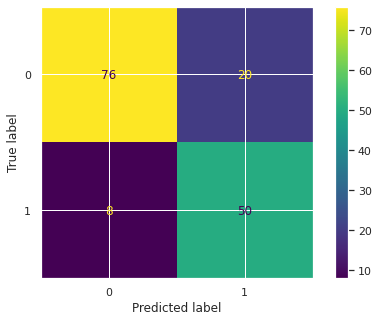

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3580           0.0244            2.47s
         2           1.3206           0.0229            2.89s
         3           1.3074           0.0213            2.68s
         4           1.2954           0.0202            2.59s
         5           1.2636           0.0191            2.51s
         6           1.2523           0.0180            2.46s
         7           1.2452           0.0171            2.42s
         8           1.2120           0.0161            2.42s
         9           1.2136           0.0150            2.39s
        10           1.1894           0.0143            2.38s
        20           1.0899           0.0085            1.88s
        30           1.0052           0.0053            1.62s
        40           0.9615           0.0039            1.48s
        50           0.9437           0.0005            1.40s
        60           0.8791           0.0021            1.33s
       

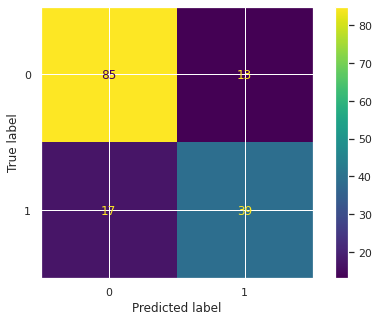

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3620           0.0225            1.22s
         2           1.3249           0.0207            2.08s
         3           1.3298           0.0197            2.24s
         4           1.2954           0.0188            3.70s
         5           1.2738           0.0176            3.30s
         6           1.2632           0.0165            3.04s
         7           1.2533           0.0157            2.85s
         8           1.2239           0.0146            2.69s
         9           1.2185           0.0139            2.58s
        10           1.1876           0.0130            2.49s
        20           1.1147           0.0081            1.75s
        30           1.0219           0.0049            1.52s
        40           1.0042           0.0028            1.38s
        50           0.9852           0.0015            1.32s
        60           0.9172           0.0021            1.27s
       

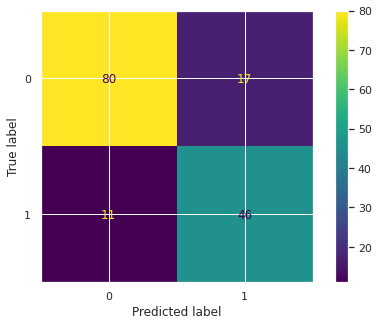

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3714           0.0236            2.01s
         2           1.3424           0.0226            2.09s
         3           1.3095           0.0209            2.01s
         4           1.2946           0.0197            1.96s
         5           1.2668           0.0186            1.91s
         6           1.2614           0.0175            1.88s
         7           1.2385           0.0165            1.86s
         8           1.2252           0.0157            1.84s
         9           1.2071           0.0148            1.82s
        10           1.1962           0.0141            1.81s
        20           1.0702           0.0083            1.43s
        30           1.0351           0.0049            1.29s
        40           0.9992           0.0031            1.24s
        50           0.9009           0.0026            1.26s
        60           0.8868           0.0020            1.21s
       

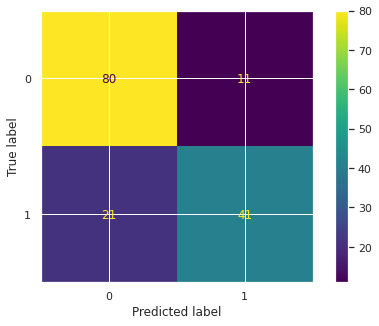

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2834           0.0192            2.13s
         2           1.2866           0.0174            2.21s
         3           1.2936           0.0170            2.21s
         4           1.2673           0.0155            2.11s
         5           1.2434           0.0145            2.29s
         6           1.2382           0.0140            2.83s
         7           1.2134           0.0130            2.76s
         8           1.1976           0.0114            2.69s
         9           1.2127           0.0114            2.63s
        10           1.1929           0.0103            2.58s
        20           1.1027           0.0062            1.87s
        30           1.0215           0.0037            1.58s
        40           1.0078           0.0029            1.43s
        50           1.0104           0.0012            1.36s
        60           0.9502           0.0018            1.29s
       

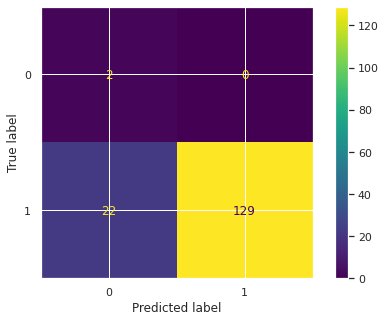


===================[검증]===================
acc_mean : 0.8177234530175707
rec_mean : 0.7762220078295392
prec_mean : 0.7965811965811966
f1_mean : 0.7821731411862991


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

X = x_train_over.values
Y = y_train_over.values
validation = []
kfold = KFold(n_splits=5)
# clf = joblib.load('clf_Titanic_GB_v2.2.0.pkl')

for train_index, test_index in kfold.split(X):
    x_train, x_val = X[train_index], X[test_index]
    y_train, y_val = Y[train_index], Y[test_index]

    clf = make_pipeline(
        RobustScaler(),
        GradientBoostingClassifier(
            init = None,
            criterion = 'friedman_mse',
            learning_rate = 0.03,
            loss = 'deviance',
            max_depth = 8,
            max_features = 'auto',
            max_leaf_nodes = 2,
            min_samples_leaf = 2,
            min_samples_split = 2,
            n_estimators = 1000,
            n_iter_no_change = 300,
            subsample = 0.5,
            tol = 0.05,
            verbose = 1,
            random_state=2
        )
    )

    y_pred = clf.fit(x_train, y_train).predict(x_val)
    validation.append(
        (
            accuracy_score(y_val, y_pred),
            recall_score(y_val, y_pred),
            precision_score(y_val, y_pred),
            f1_score(y_val, y_pred)
         )
    )

    print(f'accuracy_score : {accuracy_score(y_val, y_pred)}')
    print(f'recall_score : {recall_score(y_val, y_pred)}')
    print(f'precision_score : {precision_score(y_val, y_pred)}')
    print(f'f1_score : {f1_score(y_val, y_pred)}')
    print()

    sns.set_theme()
    plt.rcParams['figure.figsize'] = (8, 5)

    conf = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix(y_val, y_pred),
        display_labels = clf.classes_
    )
    conf.plot()

    plt.show()

acc_mean = np.mean([x[0] for x in validation])
rec_mean = np.mean([x[1] for x in validation])
prec_mean = np.mean([x[2] for x in validation])
f1_mean = np.mean([x[3] for x in validation])

print()
print('===================[검증]===================')
print(f'acc_mean : {acc_mean}')
print(f'rec_mean : {rec_mean}')
print(f'prec_mean : {prec_mean}')
print(f'f1_mean : {f1_mean}')

#### D. [평가] Predict on test data & Check the result with metrics

In [ ]:
y_pred = clf.predict(x_test)

print()
print('===================[평가]===================')
print(f'accuracy_score : {accuracy_score(y_test, y_pred)}')
print(f'recall_score : {recall_score(y_test, y_pred)}')
print(f'precision_score : {precision_score(y_test, y_pred)}')
print(f'f1_score : {f1_score(y_test, y_pred)}')


===================[평가]===================
accuracy_score : 0.8022388059701493
recall_score : 0.6407766990291263
precision_score : 0.8048780487804879
f1_score : 0.7135135135135137


### Phase 1. Parch, Fare, Cabin column 포함

#### A. [데이터 셋 생성] Train - Test split

In [ ]:
from sklearn.model_selection import train_test_split

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/도원결의 시즌2/dowon/도원/titanic.csv', encoding='utf-8', engine='python')

x_train, x_test, y_train, y_test = train_test_split(
    df.drop(['Survived'], axis=1),
    df['Survived'],
    test_size=0.3, shuffle=True, stratify=df['Survived']
)

# train 데이터 셋에 대한 df => Age에 결측값에 mean()으로 채워넣기 위한 빌드업
df = pd.concat([x_train, y_train], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
666,667,2,"Butler, Mr. Reginald Fenton",male,25.0,0,0,234686,13.0000,NaN,S,0
266,267,3,"Panula, Mr. Ernesti Arvid",male,16.0,4,1,3101295,39.6875,NaN,S,0
870,871,3,"Balkic, Mr. Cerin",male,26.0,0,0,349248,7.8958,NaN,S,0
412,413,1,"Minahan, Miss. Daisy E",female,33.0,1,0,19928,90.0000,C78,Q,1
392,393,3,"Gustafsson, Mr. Johan Birger",male,28.0,2,0,3101277,7.9250,NaN,S,0


In [ ]:
import numpy as np

def unify_cabin(x):
    result = ""
    if type(x) == float:
        return np.nan
    result = x[0]
    return result


def convert_name(name:str) -> str:
    return name.split()[0]


def find_missing_elements(arr1, arr2):
    missing_elements = []
    for element in arr1:
        if element not in arr2:
            missing_elements.append(element)
    return missing_elements

In [ ]:
from sklearn.preprocessing import LabelEncoder

df.Cabin = df.Cabin.apply(unify_cabin)
encoder = LabelEncoder()
df.Cabin = encoder.fit_transform(df.Cabin)

df_test.Cabin = df_test.Cabin.apply(unify_cabin)
encoder = LabelEncoder()
df_test.Cabin = encoder.fit_transform(df_test.Cabin)

# Cabin 원핫인코딩 안하는 이유 : 객실 알파벳에 따라 분류하면 8개 클래스가 나옴.
# 젤 적게 나오는 클래스인 8번 클래스가 한참 이전의 train_test_split 과정에서 균등하게 분리되지를 않음. => x_train과 x_test 데이터 셋 column 갯수가 달라짐.

# one_hot = pd.get_dummies(df.Cabin)
# one_hot_column_1 = list(map(str, one_hot.columns.tolist()))
# one_hot.columns = one_hot_column_1
# df = pd.concat([df, one_hot], axis=1)

# one_hot = pd.get_dummies(df_test.Cabin)
# one_hot_column_2 = list(map(str, one_hot.columns.tolist()))
# one_hot.columns = one_hot_column_2
# df_test = pd.concat([df_test, one_hot], axis=1)

# df.drop(find_missing_elements(df.columns, df_test.columns), axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

import math
import warnings

warnings.filterwarnings("ignore")

# train 데이터 처리
## Sex column 처리
encoder = LabelEncoder()
df.Sex = encoder.fit_transform(df.Sex)

## Age column 결측값 채우기
cond_1 = df.loc[(df.SibSp == 0) & (df.Parch == 0)].index
cond_2 = df.loc[(df.Pclass == 3) | (df.Sex == "male") | (df.Survived == 0)].index
new_df = df.loc[cond_1 & cond_2]
df.Age.fillna(int(round(new_df.Age.mean(), 0)), inplace=True)
df.loc[df.Age % 1 != 0, "Age"] = df.loc[df.Age % 1 != 0, "Age"].apply(math.floor)
df.Age = df.Age.astype(int)

## Embarked column 처리 [결측값, 원핫인코딩]
df.Embarked.fillna("S", inplace=True)
df = pd.concat([df, pd.get_dummies(df.Embarked)], axis=1)
df.drop(['Embarked'], axis=1, inplace=True)

In [ ]:
# test 데이터 처리
## Sex column 처리
encoder = LabelEncoder()
df_test.Sex = encoder.fit_transform(df_test.Sex)

## Age column 결측값 채우기
cond_1 = df.loc[(df.SibSp == 0) & (df.Parch == 0)].index
cond_2 = df.loc[(df.Pclass == 3) | (df.Sex == "male") | (df.Survived == 0)].index
new_df = df.loc[cond_1 & cond_2]

df_test.Age.fillna(int(round(new_df.Age.mean(), 0)), inplace=True)
df_test.loc[df_test.Age % 1 != 0, "Age"] = df_test.loc[df_test.Age % 1 != 0, "Age"].apply(math.floor)
df_test.Age = df_test.Age.astype(int)

## Embarked column 처리 [결측값, 원핫인코딩]
df_test.Embarked.fillna("S", inplace=True)
df_test = pd.concat([df_test, pd.get_dummies(df_test.Embarked)], axis=1)
df_test.drop(['Embarked'], axis=1, inplace=True)


## object column 3가지['PassengerId', 'Ticket', ] 제거
df.drop(['PassengerId', 'Ticket', 'Name', ], axis=1, inplace=True)

## object column 3가지['PassengerId', 'Ticket', 'Name'] 제거
df_test.drop(['PassengerId', 'Ticket', 'Name', ], axis=1, inplace=True)

x_train = df.drop(['Survived', ], axis=1)
x_test = df_test.drop(['Survived'], axis=1)

y_train.value_counts()

0    384
1    239
Name: Survived, dtype: int64

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

temp_df = pd.DataFrame()
X = x_train.copy()
# x_train.drop(['S', ], axis=1, inplace=True)
# x_test.drop(['S', ], axis=1, inplace=True)
# X.drop(['S', ], axis=1, inplace=True)
temp_df['Feature'] = X.columns
temp_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
temp_df

,Feature,VIF
0,Pclass,2.930043
1,Sex,1.172026
2,Age,1.285985
3,SibSp,1.361381
4,Parch,1.488426
5,Fare,1.773255
6,Cabin,2.412366
7,C,7.555447
8,Q,4.168464
9,S,27.600145


In [ ]:
#@title 오버샘플링
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

smote = SMOTE(random_state=42) # SMOTE 객체 생성

# 그냥 전처리가 아니라 단순히 SMOTE 기법을 시도하는 것이기 때문에 그냥 다버리고 오버샘플링 한번 보자.
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)

pd.DataFrame(y_train_over).Survived.value_counts() # SMOTE 를 활용한 오버샘플링 적용 된 것 확인

0    384
1    384
Name: Survived, dtype: int64

In [ ]:
#@title 언더샘플링

# y_train_df = pd.DataFrame(y_train, columns=["Survived"])
# idx_0 = y_train_df.loc[y_train_df.Survived == 0].sample(y_train.value_counts()[1], random_state=68).index.tolist()
# idx_1 = y_train_df.loc[y_train_df.Survived == 1].index.tolist()
# random_idx = idx_0 + idx_1
# x_train_under = x_train.loc[random_idx]
# y_train_under = y_train_df.loc[random_idx]

# print(x_train_under.shape, '\n')
# print(y_train_under.shape, '\n')

In [ ]:
# y_train_under.value_counts()

#### B&C. [학습 & 검증] Create model instance variable & Train the model

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3538           0.0221            1.77s
         2           1.3481           0.0205            5.65s
         3           1.3148           0.0194            4.54s
         4           1.2887           0.0184            3.99s
         5           1.2580           0.0169            4.88s
         6           1.2792           0.0162            4.47s
         7           1.2594           0.0153            4.15s
         8           1.2354           0.0147            3.90s
         9           1.2095           0.0138            4.52s
        10           1.1931           0.0128            4.29s
        20           1.1374           0.0059            3.88s
        30           1.0441           0.0053            4.08s
        40           0.9727           0.0028            4.61s
        50           0.9576           0.0024            4.62s
        60           0.9638           0.0019            4.44s
       

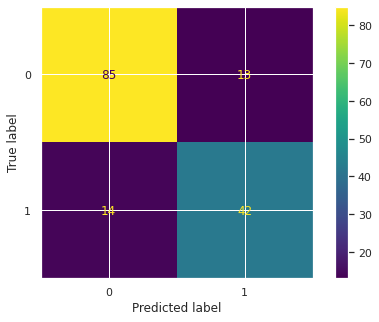

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3571           0.0217            1.79s
         2           1.3435           0.0204            2.32s
         3           1.3150           0.0192            2.33s
         4           1.2960           0.0180            2.34s
         5           1.2852           0.0170            2.36s
         6           1.2734           0.0162            2.37s
         7           1.2554           0.0156            2.35s
         8           1.2165           0.0143            2.33s
         9           1.2332           0.0136            2.31s
        10           1.2127           0.0128            2.29s
        20           1.1372           0.0064            2.04s
        30           1.0214           0.0051            1.90s
        40           0.9595           0.0037            2.19s
        50           0.9654           0.0026            2.36s
        60           0.9882           0.0019            2.74s
       

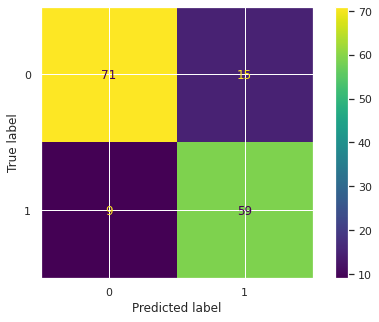

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3599           0.0231            1.86s
         2           1.3488           0.0213            2.33s
         3           1.3183           0.0204            2.39s
         4           1.2913           0.0191            2.37s
         5           1.2818           0.0181            2.40s
         6           1.2533           0.0166            2.39s
         7           1.2517           0.0161            2.40s
         8           1.2450           0.0151            2.38s
         9           1.2232           0.0145            2.36s
        10           1.2048           0.0135            2.37s
        20           1.0673           0.0079            1.97s
        30           1.0246           0.0053            1.82s
        40           0.9836           0.0037            2.41s
        50           0.9041           0.0025            2.26s
        60           0.8352           0.0016            2.13s
       

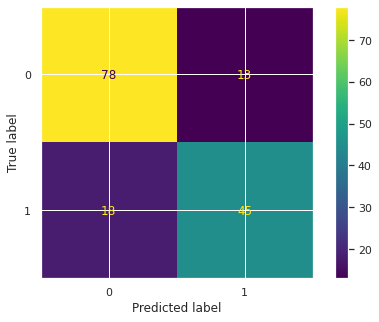

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3510           0.0251            1.73s
         2           1.3368           0.0238            2.19s
         3           1.3037           0.0224            2.19s
         4           1.3082           0.0209            2.20s
         5           1.2613           0.0200            2.21s
         6           1.2431           0.0189            2.19s
         7           1.2243           0.0178            2.18s
         8           1.2222           0.0169            2.18s
         9           1.1858           0.0159            2.18s
        10           1.1774           0.0151            2.17s
        20           1.0703           0.0089            1.83s
        30           0.9905           0.0051            1.72s
        40           0.8974           0.0036            1.66s
        50           0.9465           0.0030            1.61s
        60           0.9018           0.0023            1.58s
       

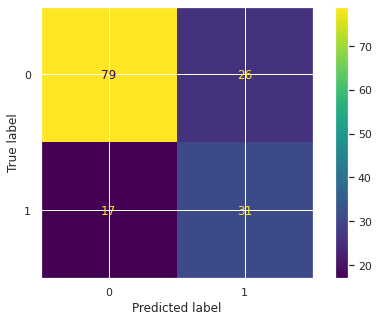

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3020           0.0173            1.68s
         2           1.3051           0.0155            2.21s
         3           1.2842           0.0153            2.25s
         4           1.2647           0.0140            2.22s
         5           1.2189           0.0130            2.20s
         6           1.2218           0.0119            2.19s
         7           1.1954           0.0117            2.18s
         8           1.1973           0.0112            2.17s
         9           1.2035           0.0108            2.17s
        10           1.1778           0.0094            2.17s
        20           1.1354           0.0049            1.83s
        30           1.1043           0.0004            1.75s
        40           1.0327           0.0033            1.68s
        50           0.9787           0.0024            1.66s
        60           0.9721           0.0006            1.62s
       

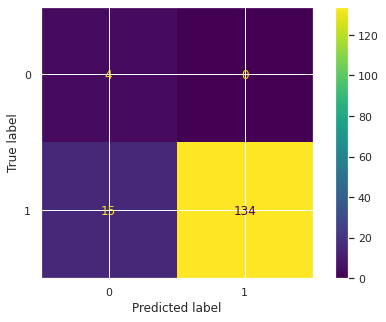


===================[검증]===================
acc_mean : 0.8176895000424412
rec_mean : 0.775418993100596
prec_mean : 0.7761310758043971
f1_mean : 0.7738033964099126


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

X = x_train_over.values
Y = y_train_over.values
validation = []
kfold = KFold(n_splits=5)
#clf = joblib.load('clf_Titanic_GB_v1.7.0.pkl')

for train_index, test_index in kfold.split(X):
    x_train, x_val = X[train_index], X[test_index]
    y_train, y_val = Y[train_index], Y[test_index]

    clf = make_pipeline(
        RobustScaler(),
        GradientBoostingClassifier(
            init = None,
            criterion = 'friedman_mse',
            learning_rate = 0.03,
            loss = 'deviance',
            max_depth = 8,
            max_features = 'auto',
            max_leaf_nodes = 2,
            min_samples_leaf = 2,
            min_samples_split = 2,
            n_estimators = 1000,
            n_iter_no_change = 300,
            subsample = 0.5,
            tol = 0.05,
            verbose = 1,
            random_state=1
        )
    )

    y_pred = clf.fit(x_train, y_train).predict(x_val)
    validation.append(
        (
            accuracy_score(y_val, y_pred),
            recall_score(y_val, y_pred),
            precision_score(y_val, y_pred),
            f1_score(y_val, y_pred)
         )
    )

    print(f'accuracy_score : {accuracy_score(y_val, y_pred)}')
    print(f'recall_score : {recall_score(y_val, y_pred)}')
    print(f'precision_score : {precision_score(y_val, y_pred)}')
    print(f'f1_score : {f1_score(y_val, y_pred)}')
    print()

    sns.set_theme()
    plt.rcParams['figure.figsize'] = (8, 5)

    conf = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix(y_val, y_pred),
        display_labels = clf.classes_
    )
    conf.plot()

    plt.show()

acc_mean = np.mean([x[0] for x in validation])
rec_mean = np.mean([x[1] for x in validation])
prec_mean = np.mean([x[2] for x in validation])
f1_mean = np.mean([x[3] for x in validation])

print()
print('===================[검증]===================')
print(f'acc_mean : {acc_mean}')
print(f'rec_mean : {rec_mean}')
print(f'prec_mean : {prec_mean}')
print(f'f1_mean : {f1_mean}')

#### D. [평가] Predict on test data & Check the result with metrics

In [ ]:
y_pred = clf.predict(x_test)

print()
print('===================[평가]===================')
print(f'accuracy_score : {accuracy_score(y_test, y_pred)}')
print(f'recall_score : {recall_score(y_test, y_pred)}')
print(f'precision_score : {precision_score(y_test, y_pred)}')
print(f'f1_score : {f1_score(y_test, y_pred)}')


===================[평가]===================
accuracy_score : 0.8246268656716418
recall_score : 0.7864077669902912
precision_score : 0.7641509433962265
f1_score : 0.7751196172248804


## 각각의 Phase 마다 모델 피클 파일로 저장
- 하이퍼 파라미터 찾는 것 > 그리드 서치 
- 오래걸려서 걸리는 동안 업무분담

In [ ]:
# import joblib

# joblib.dump(clf, 'clf_Titanic_GB_v3.1.1.pkl', compress=True)

## 다. 시도 

### ㄱ. 하이퍼 파라미터 

#### 하이퍼파라미터 적용 전

In [ ]:
?GradientBoostingClassifier

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, classification_report

X = x_train_over.values
Y = y_train_over.values
kfold = KFold(n_splits=5)

for train_index, test_index in kfold.split(X):
    x_train, x_val = X[train_index], X[test_index]
    y_train, y_val = Y[train_index], Y[test_index]

    model = make_pipeline(
        RobustScaler(),
        GradientBoostingClassifier(
            random_state=1
        )
    )

    y_pred = model.fit(x_train, y_train).predict(x_val)

    print(f'accuracy_score : {accuracy_score(y_val, y_pred)}')
    print(f'recall_score : {recall_score(y_val, y_pred)}')
    print(f'precision_score : {precision_score(y_val, y_pred)}')
    print(f'f1_score : {f1_score(y_val, y_pred)}')
    print()

y_pred = model.predict(x_test)

print(f'accuracy_score : {accuracy_score(y_test, y_pred)}')
print(f'recall_score : {recall_score(y_test, y_pred)}')
print(f'precision_score : {precision_score(y_test, y_pred)}')
print(f'f1_score : {f1_score(y_test, y_pred)}')
print()

accuracy_score : 0.8311688311688312
recall_score : 0.7321428571428571
precision_score : 0.7884615384615384
f1_score : 0.7592592592592592

accuracy_score : 0.8896103896103896
recall_score : 0.8529411764705882
precision_score : 0.8923076923076924
f1_score : 0.8721804511278195

accuracy_score : 0.7792207792207793
recall_score : 0.6984126984126984
precision_score : 0.7457627118644068
f1_score : 0.7213114754098361

accuracy_score : 0.7647058823529411
recall_score : 0.6666666666666666
precision_score : 0.6153846153846154
f1_score : 0.64

accuracy_score : 0.8823529411764706
recall_score : 0.8791946308724832
precision_score : 1.0
f1_score : 0.9357142857142857

accuracy_score : 0.8134328358208955
recall_score : 0.7572815533980582
precision_score : 0.7572815533980582
f1_score : 0.7572815533980582



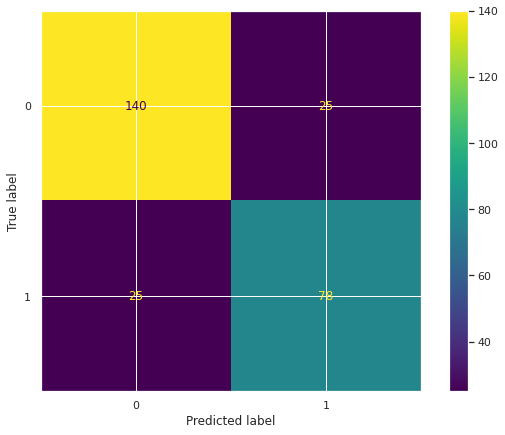

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 7)

conf = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred),
    display_labels = model.classes_
)
conf.plot()

plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       165
           1       0.76      0.76      0.76       103

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268



In [ ]:
print(f'accuracy_score : {accuracy_score(y_test, y_pred)}')
print(f'recall_score : {recall_score(y_test, y_pred)}')
print(f'precision_score : {precision_score(y_test, y_pred)}')
print(f'f1_score : {f1_score(y_test, y_pred)}')

accuracy_score : 0.8134328358208955
recall_score : 0.7572815533980582
precision_score : 0.7572815533980582
f1_score : 0.7572815533980582


#### 하이퍼파라미터 적용 후

accuracy_score : 0.8441558441558441
recall_score : 0.8035714285714286
precision_score : 0.7758620689655172
f1_score : 0.7894736842105263



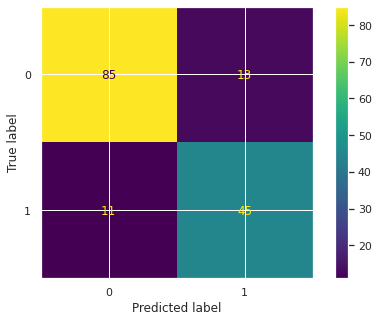

accuracy_score : 0.8441558441558441
recall_score : 0.8088235294117647
precision_score : 0.8333333333333334
f1_score : 0.8208955223880597



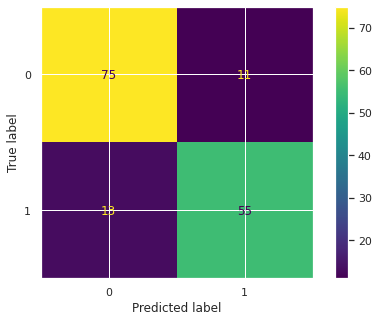

accuracy_score : 0.7857142857142857
recall_score : 0.7777777777777778
precision_score : 0.7205882352941176
f1_score : 0.7480916030534351



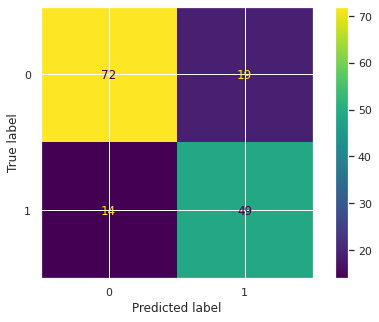

accuracy_score : 0.7973856209150327
recall_score : 0.7083333333333334
precision_score : 0.6666666666666666
f1_score : 0.6868686868686869



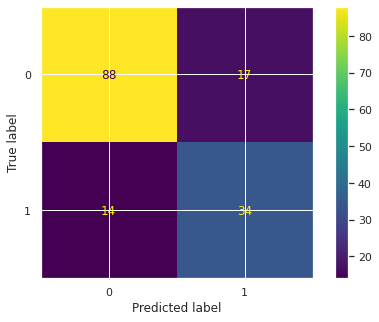

accuracy_score : 0.9084967320261438
recall_score : 0.9060402684563759
precision_score : 1.0
f1_score : 0.9507042253521127



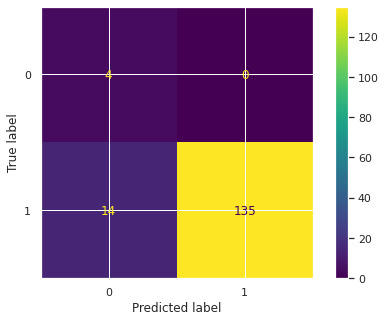

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import GradientBoostingClassifier, StackingRegressor, HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, classification_report

import matplotlib.pyplot as plt

X = x_train_over.values
Y = y_train_over.values
kfold = KFold(n_splits=5)

for train_index, test_index in kfold.split(X):
    x_train, x_val = X[train_index], X[test_index]
    y_train, y_val = Y[train_index], Y[test_index]

    model = make_pipeline(
        RobustScaler(),
        GradientBoostingClassifier(
            criterion = 'squared_error',
            learning_rate = 0.05,
            loss = 'exponential',
            max_depth = 10,
            min_samples_leaf = 2,
            min_samples_split = 4,
            n_estimators = 500,
            subsample = 0.5,
            random_state=2
        )
    )


    y_pred = model.fit(x_train, y_train).predict(x_val)


    print(f'accuracy_score : {accuracy_score(y_val, y_pred)}')
    print(f'recall_score : {recall_score(y_val, y_pred)}')
    print(f'precision_score : {precision_score(y_val, y_pred)}')
    print(f'f1_score : {f1_score(y_val, y_pred)}')
    print()

    plt.rcParams['figure.figsize'] = (8, 5)

    conf = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix(y_val, y_pred),
        display_labels = model.classes_
    )
    conf.plot()

    plt.show()

In [ ]:
# print(classification_report(y_test, y_pred))

In [ ]:
# print(f'accuracy_score : {accuracy_score(y_test, y_pred)}')
# print(f'recall_score : {recall_score(y_test, y_pred)}')
# print(f'precision_score : {precision_score(y_test, y_pred)}')
# print(f'f1_score : {f1_score(y_test, y_pred)}')

#### 실험

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3584           0.0212            1.82s
         2           1.3484           0.0199            2.33s
         3           1.3140           0.0186            4.61s
         4           1.3031           0.0173            4.12s
         5           1.2736           0.0162            4.70s
         6           1.2742           0.0156            4.33s
         7           1.2496           0.0147            5.07s
         8           1.2407           0.0140            4.74s
         9           1.2095           0.0130            4.47s
        10           1.2132           0.0123            4.84s
        20           1.1086           0.0072            4.94s
        30           1.0488           0.0041            4.30s
        40           1.0374           0.0028            3.91s
        50           1.0071           0.0023            3.86s
        60           0.9557           0.0002            3.91s
       

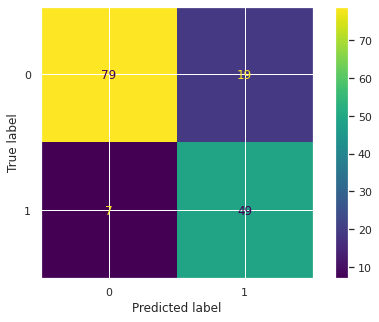

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3591           0.0221            1.70s
         2           1.3494           0.0209            2.03s
         3           1.3228           0.0200            2.03s
         4           1.3008           0.0188            2.09s
         5           1.2848           0.0172            2.04s
         6           1.2785           0.0166            1.98s
         7           1.2360           0.0155            2.04s
         8           1.2282           0.0148            2.00s
         9           1.2179           0.0138            1.97s
        10           1.2430           0.0128            1.94s
        20           1.1122           0.0077            1.49s
        30           1.0528           0.0057            1.36s
        40           0.9852           0.0023            1.42s
        50           0.9907           0.0023            1.38s
        60           0.9162           0.0019            1.31s
       

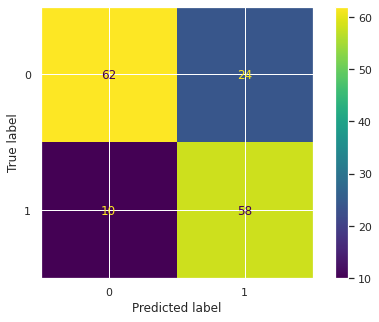

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3558           0.0226            2.13s
         2           1.3396           0.0212            2.25s
         3           1.3157           0.0201            2.12s
         4           1.3052           0.0192            2.04s
         5           1.2883           0.0180            1.99s
         6           1.2614           0.0166            1.94s
         7           1.2576           0.0156            1.92s
         8           1.2379           0.0152            1.89s
         9           1.2199           0.0143            1.87s
        10           1.2031           0.0135            1.85s
        20           1.1320           0.0059            1.50s
        30           1.0631           0.0039            1.54s
        40           0.9679           0.0035            1.47s
        50           0.9824           0.0028            1.38s
        60           0.9454          -0.0002            1.31s
       

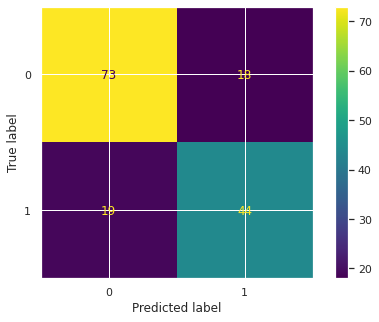

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3471           0.0263            2.12s
         2           1.3293           0.0249            2.15s
         3           1.3080           0.0233            2.04s
         4           1.2731           0.0219            1.99s
         5           1.2523           0.0207            2.09s
         6           1.2370           0.0191            2.23s
         7           1.2293           0.0185            2.18s
         8           1.1945           0.0174            2.12s
         9           1.1935           0.0165            2.07s
        10           1.1690           0.0157            2.03s
        20           1.0481           0.0089            1.55s
        30           0.9713           0.0058            1.38s
        40           0.9219           0.0033            1.30s
        50           0.8996           0.0028            1.26s
        60           0.8866           0.0021            1.22s
       

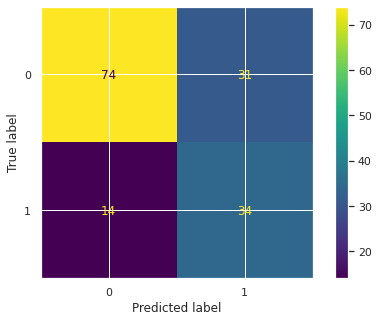

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3124           0.0196            1.99s
         2           1.3452           0.0166            2.10s
         3           1.2823           0.0164            2.00s
         4           1.2652           0.0153            1.95s
         5           1.2354           0.0146            1.90s
         6           1.2438           0.0134            1.89s
         7           1.2081           0.0130            1.86s
         8           1.2142           0.0118            1.85s
         9           1.2310           0.0112            1.82s
        10           1.1984           0.0105            1.80s
        20           1.1346           0.0041            1.50s
        30           1.0647           0.0037            1.34s
        40           1.0259           0.0024            1.26s
        50           1.0000           0.0027            1.21s
        60           0.9648           0.0006            1.17s
       

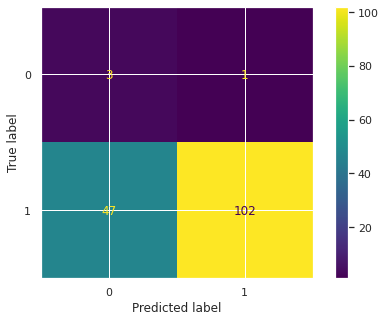


===================[검증]===================
acc_mean : 0.7524573465749936
rec_mean : 0.7638501933211763
prec_mean : 0.7301901826065067
f1_mean : 0.7357899270013457


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

X = x_train_over.values
Y = y_train_over.values
validation = []
kfold = KFold(n_splits=5)
# clf = joblib.load("clf_Titanic_GB_v1.pkl")

for train_index, test_index in kfold.split(X):
    x_train, x_val = X[train_index], X[test_index]
    y_train, y_val = Y[train_index], Y[test_index]

    # 모델 정의하기
    estimators = [
        ('svc', SVC()),
        ('gb', make_pipeline
            (
                RobustScaler(), 
                GradientBoostingClassifier(
                    init = None,
                    criterion = 'friedman_mse',
                    learning_rate = 0.03,
                    loss = 'deviance',
                    max_depth = 8,
                    max_features = 'auto',
                    max_leaf_nodes = 2,
                    min_samples_leaf = 2,
                    min_samples_split = 2,
                    n_estimators = 1000,
                    n_iter_no_change = 300,
                    subsample = 0.5,
                    tol = 0.05,
                    verbose = 1,
                    random_state=10
                )
            )
        )
    ]

    # 메타 모델 정의하기
    clf = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(penalty='l2', C=0.1)
    )

    y_pred = clf.fit(x_train, y_train).predict(x_val)
    validation.append(
        (
            accuracy_score(y_val, y_pred),
            recall_score(y_val, y_pred),
            precision_score(y_val, y_pred),
            f1_score(y_val, y_pred)
         )
    )

    print(f'accuracy_score : {accuracy_score(y_val, y_pred)}')
    print(f'recall_score : {recall_score(y_val, y_pred)}')
    print(f'precision_score : {precision_score(y_val, y_pred)}')
    print(f'f1_score : {f1_score(y_val, y_pred)}')
    print()

    sns.set_theme()
    plt.rcParams['figure.figsize'] = (8, 5)

    conf = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix(y_val, y_pred),
        display_labels = clf.classes_
    )
    conf.plot()

    plt.show()

acc_mean = np.mean([x[0] for x in validation])
rec_mean = np.mean([x[1] for x in validation])
prec_mean = np.mean([x[2] for x in validation])
f1_mean = np.mean([x[3] for x in validation])

print()
print('===================[검증]===================')
print(f'acc_mean : {acc_mean}')
print(f'rec_mean : {rec_mean}')
print(f'prec_mean : {prec_mean}')
print(f'f1_mean : {f1_mean}')

#### 평가

In [ ]:
y_pred = clf.predict(x_test)

print()
print('===================[평가]===================')
print(f'accuracy_score : {accuracy_score(y_test, y_pred)}')
print(f'recall_score : {recall_score(y_test, y_pred)}')
print(f'precision_score : {precision_score(y_test, y_pred)}')
print(f'f1_score : {f1_score(y_test, y_pred)}')


===================[평가]===================
accuracy_score : 0.8022388059701493
recall_score : 0.6310679611650486
precision_score : 0.8125
f1_score : 0.7103825136612022


### ㄴ. Name, Parch, Fare, Cabin column 포함시도 

#### 데이터 셋 생성

In [ ]:
from sklearn.model_selection import train_test_split

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/도원결의 시즌2/dowon/도원/titanic.csv', encoding='utf-8', engine='python')

x_train, x_test, y_train, y_test = train_test_split(
    df.drop(['Survived'], axis=1),
    df['Survived'],
    test_size=0.3, shuffle=True, stratify=df['Survived']
)

# train 데이터 셋에 대한 df => Age에 결측값에 mean()으로 채워넣기 위한 빌드업
df = pd.concat([x_train, y_train], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
649,650,3,"Stanley, Miss. Amy Zillah Elsie",female,23.0,0,0,CA. 2314,7.5500,NaN,S,1
553,554,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,2620,7.2250,NaN,C,1
164,165,3,"Panula, Master. Eino Viljami",male,1.0,4,1,3101295,39.6875,NaN,S,0
334,335,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.6500,NaN,S,1
424,425,3,"Rosblom, Mr. Viktor Richard",male,18.0,1,1,370129,20.2125,NaN,S,0


In [ ]:
df.loc[df.Name.str.contains("Panula")]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
164,165,3,"Panula, Master. Eino Viljami",male,1.0,4,1,3101295,39.6875,NaN,S,0
50,51,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,NaN,S,0
824,825,3,"Panula, Master. Urho Abraham",male,2.0,4,1,3101295,39.6875,NaN,S,0
686,687,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S,0
638,639,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.0,0,5,3101295,39.6875,NaN,S,0


In [ ]:
import numpy as np

def unify_cabin(x):
    result = ""
    if type(x) == float:
        return np.nan
    result = x[0]
    return result

def convert_name(name:str) -> str:
    return name.split()[0]

In [ ]:
from sklearn.preprocessing import LabelEncoder

df.Cabin = df.Cabin.apply(unify_cabin)
encoder = LabelEncoder()
df.Cabin = encoder.fit_transform(df.Cabin)

df_test.Cabin = df_test.Cabin.apply(unify_cabin)
encoder = LabelEncoder()
df_test.Cabin = encoder.fit_transform(df_test.Cabin)

In [ ]:
from sklearn.preprocessing import LabelEncoder

import math
import warnings

warnings.filterwarnings("ignore")

## Sex column 처리
encoder = LabelEncoder()
df.Sex = encoder.fit_transform(df.Sex)

## Age column 결측값 채우기
cond_1 = df.loc[(df.SibSp == 0) & (df.Parch == 0)].index
cond_2 = df.loc[(df.Pclass == 3) | (df.Sex == "male") | (df.Survived == 0)].index
new_df = df.loc[cond_1 & cond_2]
df.Age.fillna(int(round(new_df.Age.mean(), 0)), inplace=True)
df.loc[df.Age % 1 != 0, "Age"] = df.loc[df.Age % 1 != 0, "Age"].apply(math.floor)
df.Age = df.Age.astype(int)

## Embarked column 처리 [결측값, 원핫인코딩]
df.Embarked.fillna("S", inplace=True)
df = pd.concat([df, pd.get_dummies(df.Embarked)], axis=1)
df.drop(['Embarked'], axis=1, inplace=True)

## Name column 처리
new_df = df.loc[(df.SibSp >= 2) | (df.Parch >= 2)]
new_df.Name = new_df.Name.apply(convert_name)
df.drop(new_df.index, axis=0, inplace=True)
df = df.append(new_df)
df.Name = encoder.fit_transform(df['Name'])

### 원핫인코딩 [하지말것 => 차원의 저주]
# temp_df = pd.get_dummies(df.Name)
# temp_df.columns = list(map(str, temp_df.columns.tolist()))
# df = pd.concat([df, temp_df], axis=1)
# df.drop(['Name'], axis=1, inplace=True)

In [ ]:
# test 데이터 처리
## Sex column 처리
encoder = LabelEncoder()
df_test.Sex = encoder.fit_transform(df_test.Sex)

## Age column 결측값 채우기
cond_1 = df.loc[(df.SibSp == 0) & (df.Parch == 0)].index
cond_2 = df.loc[(df.Pclass == 3) | (df.Sex == "male") | (df.Survived == 0)].index
new_df = df.loc[cond_1 & cond_2]

df_test.Age.fillna(int(round(new_df.Age.mean(), 0)), inplace=True)
df_test.loc[df_test.Age % 1 != 0, "Age"] = df_test.loc[df_test.Age % 1 != 0, "Age"].apply(math.floor)
df_test.Age = df_test.Age.astype(int)

## Embarked column 처리 [결측값, 원핫인코딩]
df_test.Embarked.fillna("S", inplace=True)
df_test = pd.concat([df_test, pd.get_dummies(df_test.Embarked)], axis=1)
df_test.drop(['Embarked'], axis=1, inplace=True)

## Name column 처리
new_df = df_test.loc[(df_test.SibSp >= 2) | (df_test.Parch >= 2)]
new_df.Name = new_df.Name.apply(convert_name)
df_test.drop(new_df.index, axis=0, inplace=True)
df_test = df_test.append(new_df)

### 원핫인코딩 [하지말것. => 차원의 저주]
df_test.Name = encoder.fit_transform(df_test['Name'])
# temp_df = pd.get_dummies(df_test.Name)
# temp_df.columns = list(map(str, temp_df.columns.tolist()))
# df_test = pd.concat([df_test, df_test], axis=1)
# df_test.drop(['Name'], axis=1, inplace=True)


## object column 3가지['PassengerId', 'Ticket', ] 제거
df.drop(['PassengerId', 'Ticket',], axis=1, inplace=True)

## object column 3가지['PassengerId', 'Ticket', 'Name'] 제거
df_test.drop(['PassengerId', 'Ticket', ], axis=1, inplace=True)

x_train = df.drop(['Survived'], axis=1)
x_test = df_test.drop(['Survived'], axis=1)

y_train.value_counts()

0    384
1    239
Name: Survived, dtype: int64

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

temp_df = pd.DataFrame()
X = x_train.copy()
# x_train.drop(['S', 'Cabin'], axis=1, inplace=True)
# x_test.drop(['S', 'Cabin'], axis=1, inplace=True)
# X.drop(['S', 'Cabin'], axis=1, inplace=True)
temp_df['Feature'] = X.columns
temp_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
temp_df

,Feature,VIF
0,Pclass,2.859993
1,Name,1.026416
2,Sex,1.138782
3,Age,1.253756
4,SibSp,1.376380
5,Parch,1.413816
6,Fare,2.073587
7,Cabin,2.403032
8,C,7.977936
9,Q,5.806220


In [ ]:
#@title 오버샘플링
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

smote = SMOTE(random_state=42) # SMOTE 객체 생성

# 그냥 전처리가 아니라 단순히 SMOTE 기법을 시도하는 것이기 때문에 그냥 다버리고 오버샘플링 한번 보자.
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)

pd.DataFrame(y_train_over).Survived.value_counts() # SMOTE 를 활용한 오버샘플링 적용 된 것 확인

0    384
1    384
Name: Survived, dtype: int64

In [ ]:
#@title 언더샘플링

# y_train_df = pd.DataFrame(y_train, columns=["Survived"])
# idx_0 = y_train_df.loc[y_train_df.Survived == 0].sample(y_train.value_counts()[1], random_state=68).index.tolist()
# idx_1 = y_train_df.loc[y_train_df.Survived == 1].index.tolist()
# random_idx = idx_0 + idx_1
# x_train_under = x_train.loc[random_idx]
# y_train_under = y_train_df.loc[random_idx]

# print(x_train_under.shape, '\n')
# print(y_train_under.shape, '\n')

In [ ]:
# y_train_under.value_counts()

#### 학습 & 검증

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3794           0.0008            1.41s
         2           1.3874           0.0002            1.57s
         3           1.3746           0.0001            1.53s
         4           1.3751           0.0006            1.49s
         5           1.3726           0.0013            1.49s
         6           1.3815          -0.0004            1.51s
         7           1.3724           0.0010            1.53s
         8           1.3709           0.0008            1.53s
         9           1.3745          -0.0005            1.53s
        10           1.3647           0.0005            1.53s
        20           1.3617           0.0001            1.26s
        30           1.3541           0.0006            1.18s
        40           1.3438          -0.0004            1.13s
        50           1.3369          -0.0005            1.09s
        60           1.3298          -0.0011            1.06s
       

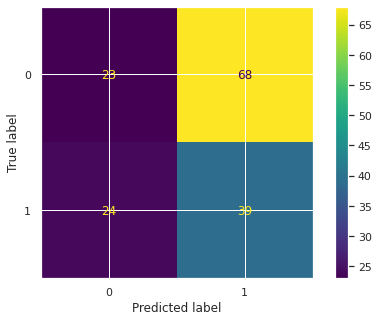

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3803           0.0005            1.22s
         2           1.3731           0.0010            1.52s
         3           1.3695           0.0005            1.50s
         4           1.3710           0.0013            1.50s
         5           1.3697           0.0018            1.54s
         6           1.3798          -0.0006            1.57s
         7           1.3589           0.0006            1.78s
         8           1.3837           0.0000            2.21s
         9           1.3645           0.0010            2.20s
        10           1.3606           0.0001            2.18s
        20           1.3416          -0.0002            1.66s
        30           1.3477           0.0009            1.44s
        40           1.3335          -0.0002            1.32s
        50           1.3216           0.0002            1.24s
        60           1.3375          -0.0006            1.19s
       

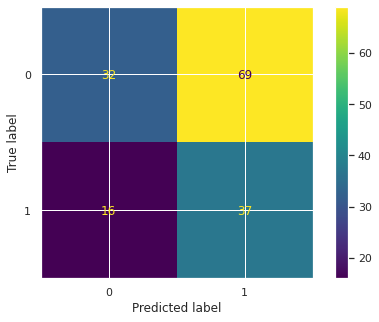

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3788          -0.0005            2.08s
         2           1.3864           0.0000            2.13s
         3           1.3766          -0.0005            2.01s
         4           1.3784           0.0002            1.95s
         5           1.3788           0.0001            1.90s
         6           1.3803          -0.0005            1.91s
         7           1.3820          -0.0012            1.96s
         8           1.3833           0.0005            1.90s
         9           1.3695          -0.0011            1.91s
        10           1.3696          -0.0002            1.88s
        20           1.3660           0.0000            1.44s
        30           1.3533          -0.0009            1.30s
        40           1.3511          -0.0001            1.21s
        50           1.3526           0.0003            1.16s
        60           1.3333          -0.0003            1.12s
       

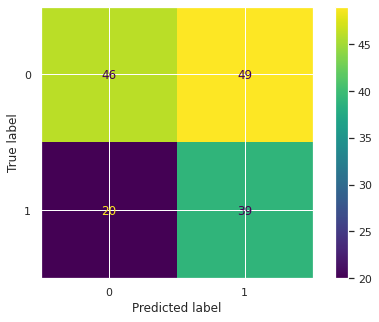

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3780          -0.0005            1.76s
         2           1.3838          -0.0002            1.90s
         3           1.3823          -0.0011            1.79s
         4           1.3736          -0.0004            1.73s
         5           1.3763           0.0012            1.68s
         6           1.3740           0.0014            1.67s
         7           1.3818          -0.0003            1.65s
         8           1.3766           0.0008            1.63s
         9           1.3850           0.0000            1.62s
        10           1.3622          -0.0011            1.61s
        20           1.3632           0.0004            1.44s
        30           1.3575           0.0002            1.30s
        40           1.3530          -0.0015            1.23s
        50           1.3420           0.0005            1.17s
        60           1.3449          -0.0003            1.15s
       

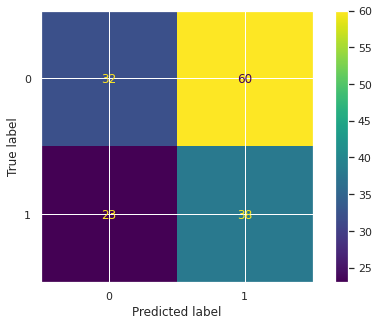

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3450          -0.0002            1.21s
         2           1.2991           0.0000            1.52s
         3           1.3638          -0.0011            1.64s
         4           1.3076           0.0001            1.61s
         5           1.3157          -0.0000            1.59s
         6           1.3373          -0.0000            1.57s
         7           1.3024          -0.0013            1.77s
         8           1.3475          -0.0008            1.80s
         9           1.3192          -0.0002            1.81s
        10           1.3225           0.0004            1.79s
        20           1.3098          -0.0004            1.93s
        30           1.3121           0.0001            1.61s
        40           1.2952           0.0002            1.44s
        50           1.3279           0.0002            1.33s
        60           1.3350          -0.0003            1.26s
       

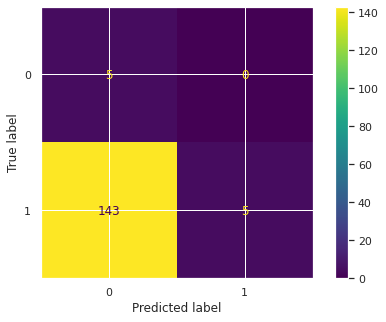


===================[검증]===================
acc_mean : 0.38509464391817333
rec_mean : 0.5269824758406492
prec_mean : 0.5088959010609261
f1_mean : 0.39963829556980024


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

X = x_train_over.values
Y = y_train_over.values
validation = []
kfold = KFold(n_splits=5)
# clf = joblib.load('clf_Titanic_GB_v2.2.0.pkl')

for train_index, test_index in kfold.split(X):
    x_train, x_val = X[train_index], X[test_index]
    y_train, y_val = Y[train_index], Y[test_index]

    clf = make_pipeline(
        RobustScaler(),
        GradientBoostingClassifier(
            init = None,
            criterion = 'friedman_mse',
            learning_rate = 0.03,
            loss = 'deviance',
            max_depth = 8,
            max_features = 'auto',
            max_leaf_nodes = 2,
            min_samples_leaf = 2,
            min_samples_split = 2,
            n_estimators = 1000,
            n_iter_no_change = 300,
            subsample = 0.5,
            tol = 0.05,
            verbose = 1,
            random_state=1
        )
    )

    y_pred = clf.fit(x_train, y_train).predict(x_val)
    validation.append(
        (
            accuracy_score(y_val, y_pred),
            recall_score(y_val, y_pred),
            precision_score(y_val, y_pred),
            f1_score(y_val, y_pred)
         )
    )

    print(f'accuracy_score : {accuracy_score(y_val, y_pred)}')
    print(f'recall_score : {recall_score(y_val, y_pred)}')
    print(f'precision_score : {precision_score(y_val, y_pred)}')
    print(f'f1_score : {f1_score(y_val, y_pred)}')
    print()

    sns.set_theme()
    plt.rcParams['figure.figsize'] = (8, 5)

    conf = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix(y_val, y_pred),
        display_labels = clf.classes_
    )
    conf.plot()

    plt.show()

acc_mean = np.mean([x[0] for x in validation])
rec_mean = np.mean([x[1] for x in validation])
prec_mean = np.mean([x[2] for x in validation])
f1_mean = np.mean([x[3] for x in validation])

print()
print('===================[검증]===================')
print(f'acc_mean : {acc_mean}')
print(f'rec_mean : {rec_mean}')
print(f'prec_mean : {prec_mean}')
print(f'f1_mean : {f1_mean}')

#### 평가

In [ ]:
y_pred = clf.predict(x_test)

print()
print('===================[평가]===================')
print(f'accuracy_score : {accuracy_score(y_test, y_pred)}')
print(f'recall_score : {recall_score(y_test, y_pred)}')
print(f'precision_score : {precision_score(y_test, y_pred)}')
print(f'f1_score : {f1_score(y_test, y_pred)}')


===================[평가]===================
accuracy_score : 0.5970149253731343
recall_score : 0.10679611650485436
precision_score : 0.4074074074074074
f1_score : 0.1692307692307692


In [ ]:
from sklearn.model_selection import train_test_split

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/도원결의 시즌2/dowon/도원/titanic.csv', encoding='utf-8', engine='python')

x_train, x_test, y_train, y_test = train_test_split(
    df.drop(['Survived'], axis=1),
    df['Survived'],
    test_size=0.3, shuffle=True, stratify=df['Survived']
)

# train 데이터 셋에 대한 df => Age에 결측값에 mean()으로 채워넣기 위한 빌드업
df = pd.concat([x_train, y_train], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
486,487,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,35.0,1,0,19943,90.0000,C93,S,1
457,458,1,"Kenyon, Mrs. Frederick R (Marion)",female,NaN,1,0,17464,51.8625,D21,S,1
338,339,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,NaN,S,1
196,197,3,"Mernagh, Mr. Robert",male,NaN,0,0,368703,7.7500,NaN,Q,0
681,682,1,"Hassab, Mr. Hammad",male,27.0,0,0,PC 17572,76.7292,D49,C,1


In [ ]:
df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            132
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          476
Embarked         1
Survived         0
dtype: int64

In [92]:
# from sklearn.model_selection import train_test_split

# ## Age column 결측값 채우기
# cond_1 = df.loc[(df.SibSp == 0) & (df.Parch == 0)].index
# cond_2 = df.loc[(df.Pclass == 3) | (df.Sex == "male") | (df.Survived == 0)].index
# new_df = df.loc[cond_1 & cond_2].select_dtypes(exclude='object').drop(['Survived'], axis=1)

# x_train, x_test, y_train, y_test = train_test_split(new_df.drop(['Age'], axis=1), new_df[['Age']], shuffle=True, stratify=new_df[['Age']])
# x_train

In [ ]:
age_train_features.isnull().sum()

PassengerId    0
Pclass         0
SibSp          0
Parch          0
Fare           0
Survived       0
dtype: int64

In [93]:
# from sklearn.linear_model import LogisticRegression

# age_train_features = df_not_age.select_dtypes(exclude='object').drop(['Age'], axis=1)
# age_train_target = df_not_age.select_dtypes(exclude='object')[['Age']]
# age_test_features = df_age.select_dtypes(exclude='object').drop(['Age'], axis=1)
# age_test_target = df_age.select_dtypes(exclude='object')[['Age']]

# model = LogisticRegression()
# model.fit(age_train_features, age_train_target)
# # predict(age_test_features)

### ㄷ. PCA 코드 구현 

- 구현 방법
- 도원결의 시즌 2 dowon 파일 Phase 2 코드에 PCA (주성분분석) 구현
1. 선생님 주신 자료. 7번 파일 (방대한 실습) 파일에 있는 PCA 코드 우리 모델에 적용시켜서 구현 , 다른 파일도 찾아볼 것 ,
피피티 파일 안에는 코드가 없고, 주석에도 코드가 없음
2. 학원에서 받은 핸즈온 머신러닝 2판에 있는 PCA 코드 보고 구현 
3. 구글링 

In [ ]:
# 문제의식 

# 어느 타이밍에 PCA를 해주는 것이 맞을까? 
# 애초에 PCA를 하려했던 이유 
# PClass 와 Cabin 이 다중공선성이 있어서 두 가지 컬럼 중 하나를 버리게 됐기 때문, 
# 문제가 있는 column들 : Parch, Fare, Cabin, Ticket
# 만약에 PCA를 해준다고 한다면, 네 개의 컬럼에 결측치가 없어야하고 컴퓨터가 돌릴 수 있게끔 원핫인코딩을 해주어야 하나?


### PCA 코드 첫시도 

In [ ]:
# from sklearn.decomposition import PCA
# # Calculating PCA for both datasets, and graphing the Variance for each feature, per dataset
# std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop('predclass', axis=1))
# X = std_scale.transform(dataset_bin_enc.drop('predclass', axis=1))
# pca1 = PCA(n_components=len(dataset_bin_enc.columns)-1)
# fit1 = pca1.fit(X)

# std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
# X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
# pca2 = PCA(n_components=len(dataset_con_enc.columns)-2)
# fit2 = pca2.fit(X)

# # Graphing the variance per feature
# plt.style.use('seaborn-whitegrid')
# plt.figure(figsize=(25,7)) 

# plt.subplot(1, 2, 1)
# plt.xlabel('PCA Feature')
# plt.ylabel('Variance')
# plt.title('PCA for Discretised Dataset')
# plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_);

# plt.subplot(1, 2, 2)
# plt.xlabel('PCA Feature')
# plt.ylabel('Variance')
# plt.title('PCA for Continuous Dataset')
# plt.bar(range(0, fit2.explained_variance_ratio_.size), fit2.explained_variance_ratio_);

In [ ]:
# from sklearn.decomposition import PCA

# pca1 = PCA(n_components=1)
# X_low = pca1.fit_transform(X)
# X2 = pca1.inverse_transform(X_low)

# plt.figure(figsize=(7, 7))
# ax = sns.scatterplot(0, 1, data=pd.DataFrame(X), s=100, color=".2", marker="s")
# for i in range(N):
#     d = 0.03 if X[i, 1] > X2[i, 1] else -0.04
#     ax.text(X[i, 0] - 0.065, X[i, 1] + d, "표본 {}".format(i + 1))
#     plt.plot([X[i, 0], X2[i, 0]], [X[i, 1], X2[i, 1]], "k--")
# plt.plot(X2[:, 0], X2[:, 1], "o-", markersize=10)
# plt.plot(X[:, 0].mean(), X[:, 1].mean(), markersize=10, marker="D")
# plt.axvline(X[:, 0].mean(), c='r')
# plt.axhline(X[:, 1].mean(), c='r')
# plt.grid(False)
# plt.xlabel("꽃받침 길이")
# plt.ylabel("꽃받침 폭")
# plt.title("Iris 데이터의 1차원 차원축소")
# plt.axis("equal")
# plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(X)

PCA(n_components=2)

In [ ]:
print(pca.explained_variance_ratio_)

# explained_variance_ratio_ndarray of shape (n_components,)
# Percentage of variance explained by each of the selected components.

[0.99244289 0.00755711]


In [ ]:
print(pca.singular_values_)

# singular_values_ndarray of shape (n_components,)
# The singular values corresponding to each of the selected components. The singular values are equal to the 2-norms of the n_components variables in the lower-dimensional space.

[6.30061232 0.54980396]


In [ ]:
pca = PCA(n_components=1, svd_solver='arpack')
pca.fit(X)

print(pca.explained_variance_ratio_)

[0.99244289]


In [ ]:
print(pca.singular_values_)

[6.30061232]


In [ ]:
first_try_df = df.drop(['Survived'], axis=1)
first_try_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### 모델링 전 전처리 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


# CSV 데이터 파일 로드 
df = pd.read_csv('/content/drive/MyDrive/도원결의 시즌2/dowon/도원/titanic.csv', encoding='utf-8', engine='python')

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### Cabin열 원핫인코딩

In [ ]:
df.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [ ]:
import numpy as np

def classificate_cabin(x):
    result = ""
    if type(x) == float:
        return np.nan
    result = x[0]
    return result

In [ ]:
df_copy = df.copy()
df_copy.Cabin = df.Cabin.apply(classificate_cabin)
cabin_columns = df_copy.Cabin.unique()

In [ ]:
df_copy.Cabin.value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_copy.Cabin = encoder.fit_transform(df_copy.Cabin)

In [ ]:
df_copy.Cabin.value_counts()

8    687
2     59
1     47
3     33
4     32
0     15
5     13
6      4
7      1
Name: Cabin, dtype: int64

In [ ]:
encoded_cabin_df = pd.get_dummies(df_copy.Cabin)
encoded_cabin_df

,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,0,0,0,1
887,0,1,0,0,0,0,0,0,0
888,0,0,0,0,0,0,0,0,1
889,0,0,1,0,0,0,0,0,0


In [ ]:
df_copy.Cabin.value_counts()

8    687
2     59
1     47
3     33
4     32
0     15
5     13
6      4
7      1
Name: Cabin, dtype: int64

In [ ]:
df_copy

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,8,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,2,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,8,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,2,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,8,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,8,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,1,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,8,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,2,C


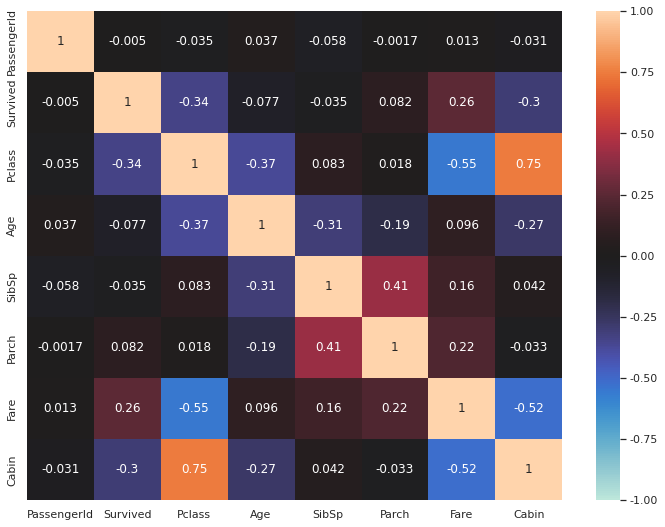

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["figure.figsize"] = (12, 9)

sns.set_theme()
sns.heatmap(df_copy.select_dtypes(exclude='object').corr(), annot=True, vmin=-1, vmax=1, cmap="icefire")

plt.show()

In [ ]:
encoded_cabin_df

,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,0,0,0,1
887,0,1,0,0,0,0,0,0,0
888,0,0,0,0,0,0,0,0,1
889,0,0,1,0,0,0,0,0,0


In [ ]:
cabin_df = pd.DataFrame(df_copy.loc[:,'Cabin'])
cabin_df

,Cabin
0,8
1,2
2,8
3,2
4,8
...,...
886,8
887,1
888,8
889,2


In [ ]:
df.drop(['Cabin'], axis=1, inplace=True)
df = pd.concat([df, cabin_df], axis=1)

In [ ]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,8
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,8
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S,8
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,2


##### Embarked 원핫인코딩  


In [ ]:
sum(df.Embarked.isnull()==True)

2

In [ ]:
df.Embarked.fillna("S", inplace=True)
df = pd.concat([df, pd.get_dummies(df.Embarked)], axis=1)
df.drop(['Embarked'], axis=1, inplace=True)

In [ ]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,8,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,2,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,8,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,2,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,8,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,8,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,1,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,8,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,2,1,0,0


##### *** 이 단계에서 모델링 적용

In [ ]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,8,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,2,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,8,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,2,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,8,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,8,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,1,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,8,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,2,1,0,0


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

from sklearn.decomposition import PCA
import numpy as np 


# 학습용데이터와 테스트데이터로 구분
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(['Survived'], axis=1),
    df['Survived'],
    test_size=0.3, shuffle=True, stratify=df['Survived']
)

# train 데이터 셋에 대한 df => Age에 결측값에 mean()으로 채워넣기 위한 빌드업
df = pd.concat([x_train, y_train], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)

from sklearn.preprocessing import LabelEncoder
import math
import warnings
warnings.filterwarnings("ignore")

## Sex column 처리
encoder = LabelEncoder()
df.Sex = encoder.fit_transform(df.Sex)

## Age column 결측값 채우기
cond_1 = df.loc[(df.SibSp == 0) & (df.Parch == 0)].index
cond_2 = df.loc[(df.Pclass == 3) | (df.Sex == "male") | (df.Survived == 0)].index
new_df = df.loc[cond_1 & cond_2]
df.Age.fillna(int(round(new_df.Age.mean(), 0)), inplace=True)
df.loc[df.Age % 1 != 0, "Age"] = df.loc[df.Age % 1 != 0, "Age"].apply(math.floor)
df.Age = df.Age.astype(int)


In [ ]:
# test 데이터 처리

## Sex column 처리
encoder = LabelEncoder()
df_test.Sex = encoder.fit_transform(df_test.Sex)

## Age column 결측값 채우기
cond_1 = df.loc[(df.SibSp == 0) & (df.Parch == 0)].index
cond_2 = df.loc[(df.Pclass == 3) | (df.Sex == "male") | (df.Survived == 0)].index
new_df = df.loc[cond_1 & cond_2]

df_test.Age.fillna(int(round(new_df.Age.mean(), 0)), inplace=True)
df_test.loc[df_test.Age % 1 != 0, "Age"] = df_test.loc[df_test.Age % 1 != 0, "Age"].apply(math.floor)
df_test.Age = df_test.Age.astype(int)

## object column 4가지['PassengerId', 'Ticket', 'Name'] 제거
df.drop(['PassengerId', 'Ticket', 'Name'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Ticket', 'Name'], axis=1, inplace=True)

x_train = df.drop(['Survived'], axis=1)
x_test = df_test.drop(['Survived'], axis=1)

In [ ]:
x_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q,S
419,3,0,10,0,2,24.1500,8,0,0,1
880,2,0,25,0,1,26.0000,8,0,0,1
778,3,1,32,0,0,7.7375,8,0,1,0
390,1,1,36,1,2,120.0000,1,0,0,1
378,3,1,20,0,0,4.0125,8,1,0,0
...,...,...,...,...,...,...,...,...,...,...
555,1,1,62,0,0,26.5500,8,0,0,1
207,3,1,26,0,0,18.7875,8,1,0,0
779,1,0,43,0,1,211.3375,1,0,0,1
105,3,1,28,0,0,7.8958,8,0,0,1


In [ ]:
x_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q,S
115,3,1,21,0,0,7.9250,8,0,0,1
45,3,1,32,0,0,8.0500,8,0,0,1
187,1,1,45,0,0,26.5500,8,0,0,1
839,1,1,32,0,0,29.7000,2,1,0,0
793,1,1,32,0,0,30.6958,8,1,0,0
...,...,...,...,...,...,...,...,...,...,...
432,2,0,42,1,0,26.0000,8,0,0,1
484,1,1,25,1,0,91.0792,1,1,0,0
631,3,1,51,0,0,7.0542,8,0,0,1
169,3,1,28,0,0,56.4958,8,0,0,1


In [ ]:
# # SMOTE Feature names are only supported if all input features have string names
# str_columns = {0:'Zero',
#                1:'One',
#                2:'Two',
#                3:'Three',
#                4:'Four',
#                5:'Five',
#                6:'Six',
#                7:'Seven',
#                8:'Eight'}

# x_train.rename(columns=str_columns, inplace=True)
# x_test.rename(columns=str_columns, inplace=True)

In [ ]:
x_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q,S
419,3,0,10,0,2,24.1500,8,0,0,1
880,2,0,25,0,1,26.0000,8,0,0,1
778,3,1,32,0,0,7.7375,8,0,1,0
390,1,1,36,1,2,120.0000,1,0,0,1
378,3,1,20,0,0,4.0125,8,1,0,0
...,...,...,...,...,...,...,...,...,...,...
555,1,1,62,0,0,26.5500,8,0,0,1
207,3,1,26,0,0,18.7875,8,1,0,0
779,1,0,43,0,1,211.3375,1,0,0,1
105,3,1,28,0,0,7.8958,8,0,0,1


In [ ]:
x_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q,S
115,3,1,21,0,0,7.9250,8,0,0,1
45,3,1,32,0,0,8.0500,8,0,0,1
187,1,1,45,0,0,26.5500,8,0,0,1
839,1,1,32,0,0,29.7000,2,1,0,0
793,1,1,32,0,0,30.6958,8,1,0,0
...,...,...,...,...,...,...,...,...,...,...
432,2,0,42,1,0,26.0000,8,0,0,1
484,1,1,25,1,0,91.0792,1,1,0,0
631,3,1,51,0,0,7.0542,8,0,0,1
169,3,1,28,0,0,56.4958,8,0,0,1


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

smote = SMOTE(random_state=42) # SMOTE 객체 생성

# 그냥 전처리가 아니라 단순히 SMOTE 기법을 시도하는 것이기 때문에 그냥 다버리고 오버샘플링 한번 보자.
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)

pd.DataFrame(y_train_over).Survived.value_counts() # SMOTE 를 활용한 오버샘플링 적용 된 것 확인

0    384
1    384
Name: Survived, dtype: int64

In [ ]:
# #@title PCA n_components=3

# rbscaler = RobustScaler().fit(x_train_over)
# scaled_x_train_over = rbscaler.transform(x_train_over)

# before_pca = pd.DataFrame(scaled_x_train_over)

# pca = PCA(n_components=3)
# x_train_over = pca.fit(before_pca)
# x_low_array = x_train_over.transform(before_pca)
# x_low = pd.DataFrame(x_low_array)
# print(x_low)

# print(pca.explained_variance_)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

In [ ]:
#@title PCA n_components=n
rbscaler = RobustScaler().fit(x_train_over)
scaled_x_train_over = rbscaler.transform(x_train_over)

before_pca = pd.DataFrame(scaled_x_train_over)

pca = PCA(n_components=3)
x_train_over = pca.fit(before_pca)
x_low_array = x_train_over.transform(before_pca)
x_low = pd.DataFrame(x_low_array)
print(x_low)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

            0         1         2
0   -0.550612  1.267768 -1.312791
1   -0.395896  0.260971 -0.532724
2   -1.206639 -0.470405 -0.091712
3    3.885865  0.428180  0.308594
4   -1.344181 -0.060998 -0.787063
..        ...       ...       ...
763  0.955297 -0.644092 -0.324789
764 -1.127470 -0.424150 -0.147370
765 -0.780336 -1.523014  1.598759
766  0.941045 -0.568388 -0.835196
767  2.846258 -0.480692 -1.411940

[768 rows x 3 columns]
[3.26860229 1.40321137 0.75391508]
[0.47185374 0.20256687 0.10883479]
[50.0701304  32.80644935 24.04688886]


accuracy_score : 0.7792207792207793
recall_score : 0.7580645161290323
precision_score : 0.7121212121212122
f1_score : 0.7343750000000001



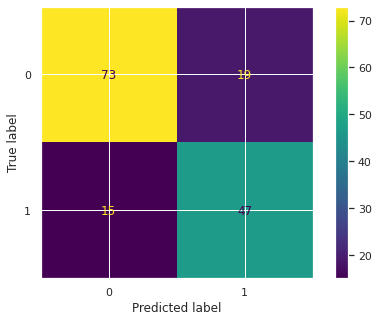

accuracy_score : 0.7077922077922078
recall_score : 0.8
precision_score : 0.5641025641025641
f1_score : 0.6616541353383458



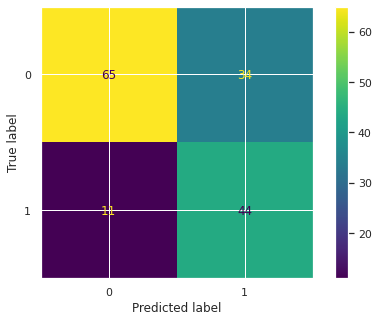

accuracy_score : 0.7792207792207793
recall_score : 0.7758620689655172
precision_score : 0.6818181818181818
f1_score : 0.7258064516129032



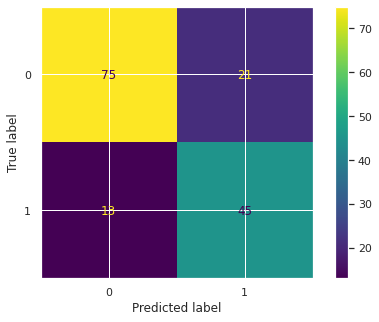

accuracy_score : 0.6928104575163399
recall_score : 0.7166666666666667
precision_score : 0.589041095890411
f1_score : 0.6466165413533834



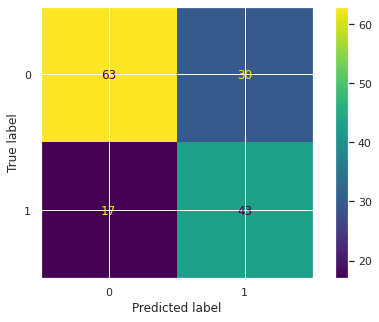

accuracy_score : 0.7777777777777778
recall_score : 0.785234899328859
precision_score : 0.9831932773109243
f1_score : 0.8731343283582089



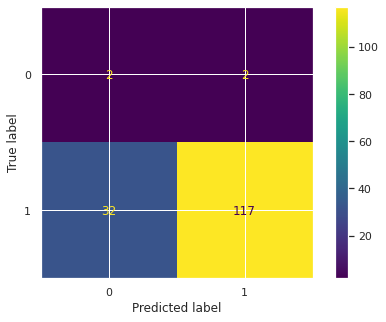


===================[검증]===================
acc_mean : 0.7473644003055767
rec_mean : 0.7671656302180151
prec_mean : 0.7060552662486587
f1_mean : 0.7283172913325683


In [ ]:
X = x_low.values
Y = y_train_over.values
validation = []
kfold = KFold(n_splits=5)
# clf = joblib.load('clf_Titanic_GB_v4.0.0.pkl')

for train_index, test_index in kfold.split(X):
    x_low, x_val = X[train_index], X[test_index]
    y_train, y_val = Y[train_index], Y[test_index]

    clf = GradientBoostingClassifier(
            criterion = 'squared_error',
            learning_rate = 0.03,
            loss = 'exponential',
            max_depth = 9,
            min_samples_leaf = 2,
            min_samples_split = 4,
            n_estimators = 700,
            subsample = 0.5,
            random_state=1)    
    
    y_pred = clf.fit(x_low, y_train).predict(x_val)
    validation.append(
        (
            accuracy_score(y_val, y_pred),
            recall_score(y_val, y_pred),
            precision_score(y_val, y_pred),
            f1_score(y_val, y_pred)
         )
    )

    print(f'accuracy_score : {accuracy_score(y_val, y_pred)}')
    print(f'recall_score : {recall_score(y_val, y_pred)}')
    print(f'precision_score : {precision_score(y_val, y_pred)}')
    print(f'f1_score : {f1_score(y_val, y_pred)}')
    print()

    sns.set_theme()
    plt.rcParams['figure.figsize'] = (8, 5)

    conf = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix(y_val, y_pred),
        display_labels = clf.classes_
    )
    conf.plot()

    plt.show()

acc_mean = np.mean([x[0] for x in validation])
rec_mean = np.mean([x[1] for x in validation])
prec_mean = np.mean([x[2] for x in validation])
f1_mean = np.mean([x[3] for x in validation])

print()
print('===================[검증]===================')
print(f'acc_mean : {acc_mean}')
print(f'rec_mean : {rec_mean}')
print(f'prec_mean : {prec_mean}')
print(f'f1_mean : {f1_mean}')

In [ ]:
validation

[(0.7792207792207793,
  0.7580645161290323,
  0.7121212121212122,
  0.7343750000000001),
 (0.7077922077922078, 0.8, 0.5641025641025641, 0.6616541353383458),
 (0.7792207792207793,
  0.7758620689655172,
  0.6818181818181818,
  0.7258064516129032),
 (0.6928104575163399,
  0.7166666666666667,
  0.589041095890411,
  0.6466165413533834),
 (0.7777777777777778,
  0.785234899328859,
  0.9831932773109243,
  0.8731343283582089)]

In [ ]:
x_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q,S
115,3,1,21,0,0,7.9250,8,0,0,1
45,3,1,32,0,0,8.0500,8,0,0,1
187,1,1,45,0,0,26.5500,8,0,0,1
839,1,1,32,0,0,29.7000,2,1,0,0
793,1,1,32,0,0,30.6958,8,1,0,0
...,...,...,...,...,...,...,...,...,...,...
432,2,0,42,1,0,26.0000,8,0,0,1
484,1,1,25,1,0,91.0792,1,1,0,0
631,3,1,51,0,0,7.0542,8,0,0,1
169,3,1,28,0,0,56.4958,8,0,0,1


In [ ]:
rbscaler = RobustScaler()
scaled_x_test = rbscaler.fit_transform(x_test)
before_pca = pd.DataFrame(scaled_x_test)

pca = PCA(n_components=3)
x_test_low_array = pca.fit_transform(before_pca)

x_test_low = pd.DataFrame(x_test_low_array)
x_test_low

,0,1,2
0,-1.354994,0.020001,0.771683
1,-1.296431,-0.444064,0.477985
2,-0.466432,-1.062077,0.167840
3,0.496014,-1.472060,-1.262511
4,-0.269124,-0.560794,0.523003
...,...,...,...
263,-0.479814,-0.135752,-0.242686
264,2.845300,-0.405400,-1.205483
265,-1.238734,-1.250195,-0.043129
266,0.421341,-0.092714,1.137806


In [ ]:
y_pred = clf.predict(x_test_low)

print()
print('===================[평가]===================')
print(f'accuracy_score : {accuracy_score(y_test, y_pred)}')
print(f'recall_score : {recall_score(y_test, y_pred)}')
print(f'precision_score : {precision_score(y_test, y_pred)}')
print(f'f1_score : {f1_score(y_test, y_pred)}')


===================[평가]===================
accuracy_score : 0.6492537313432836
recall_score : 0.4854368932038835
precision_score : 0.5494505494505495
f1_score : 0.5154639175257733


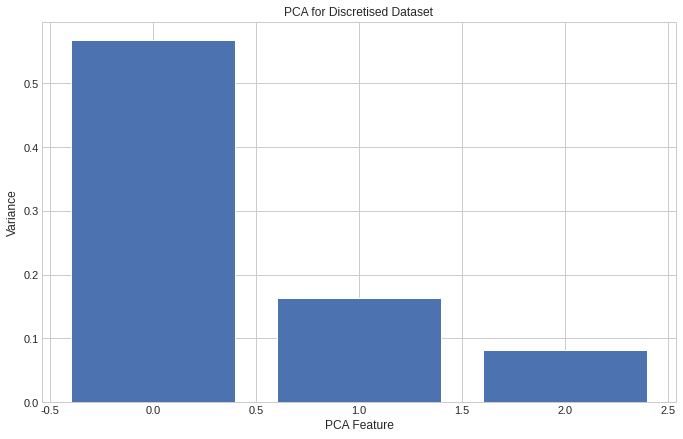

In [ ]:
# Graphing the variance per feature
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25,7)) 

plt.subplot(1, 2, 1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretised Dataset')
plt.bar(range(0, pca.explained_variance_ratio_.size), pca.explained_variance_ratio_);